# B조 파이썬 실습 : 역전파~ 신경망 관련 학습 기술



- 순전파forward propagation : 계산을 왼쪽에서 오른쪽으로 진행


- 역전파backward propagation : 계산을 반대 방향으로 진행. 미분을 효율적으로 계산할 수 있다.

### buy_apple문제
#### 슈퍼에서 1개 100원인 사과를 2개 사고 소비세가 10%일 때, 지불 금액은?

100 * 2 * 1.1 = 220

<img src ='./계산함수그림.png'  > 

-> 사과 가격이 오를 때 최종 가격에 미치는 영향(=사과 가격에 대한 지불 금액의 미분)을 구하고 싶다.
따라서 사과 값 : x, 지불 금액 : L일 때, ∂L/∂x를 구하는 것.

계산 그래프의 역전파를 이용해서 구할 수 있다.

In [1]:
# 곱셈 계층 구현
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [3]:
# 순전파(forward)
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price) # 220

220.00000000000003


In [4]:
# 역전파(backward): 호출순서가 forward() 때와 반대. backward()가 받는 인수는 '순전파의 출력에 대한 미분'임을 주의!
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print('price:', int(price)) # 220
print('dApple:', dapple) # 2.2
print('dApple_num:', int(dapple_num)) # 110
print('dTax:', dtax) # 200

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


In [5]:
# 덧셈 계층 구현
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_orange_layer= MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

In [7]:
# 순전파(forward)
apple_price = mul_apple_layer.forward(apple, apple_num) #(1)
orange_price = mul_orange_layer.forward(orange, orange_num) #(2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price) #(3)
price = mul_tax_layer.forward(all_price, tax) #(4)

print(price) # 715

715.0000000000001


In [8]:
# 역전파(backward) - 미분
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice) #(4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price) #(3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price) #(2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price) #(1)

print('price:', int(price)) # 715
print('dApple:', dapple) # 2.2
print('dApple_num:', int(dapple_num)) # 110
print('dOrange:', dorange) # 3.3
print('dOrange_num:', int(dorange_num)) # 165
print('dTax:', dtax) # 650

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 신경망 학습 순서

**전제**
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.

**1단계 - 미니배치**
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실함수 값을 줄이는 것이 목표이다.

**2단계 - 기울기 산출**
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

**3단계 - 매개변수 갱신**
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

**4단계 - 반복**
1~3단계를 반복한다.


- 수치 미분과 오차역전파법은 2단계에서 사용
- 수치 미분은 구현은 쉽지만 계산이 오래걸림
- 오차역전파법을 통해 기울기를 효율적이고 빠르게 구할 수 있음

### gradient_check(오차역전파법으로 구한 기울기 검증하기)

앞에서 설명했듯이, 기울기를 구하는데에는 두 가지 방법이 있다.
1. 수치 미분 : 느리다. 구현이 쉽다.
2. 해석적으로 수식을 풀기(오차 역전파법) : 빠르지만 실수가 있을 수 있다.

두 기울기 결과를 비교해서 오차역전파법을 제대로 구현했는지 검증한다. 이 작업을 기울기 확인(gradient check)라고 한다.

In [9]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

In [10]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균(절대 오차의 평균)을 구한다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ':' + str(diff))

b2:1.201261257133268e-10
b1:7.507472102685309e-13
W1:2.283005110575095e-13
W2:8.148377105433175e-13


결과를 확인해 보면, 수치 미분과 오차역전파법으로 구한 기울기의 차이가 매우 작다. 이는 오차역전파가 실수 없이 구현되었을 확률이 높다는 것을 의미한다.
컴퓨터가 할 수 있는 계산의 정밀도가 유한하기 때문에 수치 미분과 오차역전파법의 결과 오차는 0이 될 수 없다.

In [11]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [12]:
# 하이퍼 파라메터
iters_num = 10000 # 반복횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에포당 반복 수 (1에포: 학습 횟수)
iter_per_epoch = max(train_size / batch_size, 1)

In [13]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차역전파법으로 기울기를 구한다.
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에포당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('-------------------------------------------')
        print('train set accuracy: %s  test accuracy: %s'%(train_acc, test_acc))
        

-------------------------------------------
train set accuracy: 0.10583333333333333  test accuracy: 0.105
-------------------------------------------
train set accuracy: 0.9036  test accuracy: 0.9053
-------------------------------------------
train set accuracy: 0.92305  test accuracy: 0.9235
-------------------------------------------
train set accuracy: 0.9351666666666667  test accuracy: 0.9358
-------------------------------------------
train set accuracy: 0.9399666666666666  test accuracy: 0.9389
-------------------------------------------
train set accuracy: 0.9501833333333334  test accuracy: 0.948
-------------------------------------------
train set accuracy: 0.9546666666666667  test accuracy: 0.9521
-------------------------------------------
train set accuracy: 0.9589  test accuracy: 0.9557
-------------------------------------------
train set accuracy: 0.9603166666666667  test accuracy: 0.9569
-------------------------------------------
train set accuracy: 0.9657166666666667

# 배치정규화
> 각 층이 활성화 값을 적당히 퍼트리는 것을 강제하도록 하는 것을 배치 정규화Batch Normalization
이라고 한다.

## MNIST 데이터셋을 사용하여 학습진도 차이를 확인한다.

In [14]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

In [15]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:1000] 
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

## MultiLayerNetExtend
>완전 연결 다층 신경망(확장판)
  가중치 감소, 드롭아웃, 배치 정규화 구현
  
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
> 대부분의 초깃값 표준편차에서 학습 진도가 빠르다.

In [16]:
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100],
            output_size=10,
            weight_init_std=weight_init_std,
            use_batchnorm=True,
    )
    network = MultiLayerNetExtend(
            input_size=784,
            hidden_size_list=[100, 100, 100, 100, 100],
            output_size=10,
            weight_init_std=weight_init_std,
    )
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
            
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            
            print('epoch:' + str(epoch_cnt) + ' | ' + str(train_acc) + ' - ' + str(bn_train_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

## 그래프 시각화

==========1/16==========
epoch:0 | 0.087 - 0.122


C:\Users\jimmi\Desktop\뉴럴넷 실습\common\functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
C:\Users\jimmi\Desktop\뉴럴넷 실습\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
C:\Users\jimmi\Desktop\뉴럴넷 실습\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
C:\Users\jimmi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.128
epoch:2 | 0.097 - 0.116
epoch:3 | 0.097 - 0.128
epoch:4 | 0.097 - 0.146
epoch:5 | 0.097 - 0.169
epoch:6 | 0.097 - 0.193
epoch:7 | 0.097 - 0.216
epoch:8 | 0.097 - 0.243
epoch:9 | 0.097 - 0.253
epoch:10 | 0.097 - 0.28
epoch:11 | 0.097 - 0.29
epoch:12 | 0.097 - 0.32
epoch:13 | 0.097 - 0.341
epoch:14 | 0.097 - 0.347
epoch:15 | 0.097 - 0.357
epoch:16 | 0.097 - 0.377
epoch:17 | 0.097 - 0.385
epoch:18 | 0.097 - 0.405


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.416
==========2/16==========
epoch:0 | 0.083 - 0.098


C:\Users\jimmi\Desktop\뉴럴넷 실습\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\jimmi\Desktop\뉴럴넷 실습\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.111
epoch:2 | 0.097 - 0.14
epoch:3 | 0.097 - 0.164
epoch:4 | 0.097 - 0.188
epoch:5 | 0.097 - 0.208
epoch:6 | 0.097 - 0.24
epoch:7 | 0.097 - 0.255
epoch:8 | 0.097 - 0.279
epoch:9 | 0.097 - 0.3
epoch:10 | 0.097 - 0.318
epoch:11 | 0.097 - 0.333
epoch:12 | 0.097 - 0.357
epoch:13 | 0.097 - 0.372
epoch:14 | 0.097 - 0.393
epoch:15 | 0.097 - 0.402
epoch:16 | 0.097 - 0.419
epoch:17 | 0.097 - 0.444


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.466
epoch:19 | 0.097 - 0.475
==========3/16==========
epoch:0 | 0.125 - 0.08
epoch:1 | 0.315 - 0.118
epoch:2 | 0.424 - 0.164
epoch:3 | 0.524 - 0.218
epoch:4 | 0.606 - 0.266
epoch:5 | 0.673 - 0.315
epoch:6 | 0.685 - 0.353
epoch:7 | 0.744 - 0.38
epoch:8 | 0.791 - 0.429
epoch:9 | 0.824 - 0.458
epoch:10 | 0.854 - 0.489
epoch:11 | 0.875 - 0.525
epoch:12 | 0.897 - 0.552
epoch:13 | 0.912 - 0.587
epoch:14 | 0.927 - 0.597
epoch:15 | 0.937 - 0.622
epoch:16 | 0.94 - 0.635
epoch:17 | 0.955 - 0.647
epoch:18 | 0.961 - 0.672
epoch:19 | 0.965 - 0.686


No handles with labels found to put in legend.


==========4/16==========
epoch:0 | 0.069 - 0.066
epoch:1 | 0.184 - 0.091
epoch:2 | 0.308 - 0.152
epoch:3 | 0.407 - 0.243
epoch:4 | 0.524 - 0.322
epoch:5 | 0.579 - 0.411
epoch:6 | 0.632 - 0.48
epoch:7 | 0.664 - 0.528
epoch:8 | 0.706 - 0.577
epoch:9 | 0.73 - 0.613
epoch:10 | 0.75 - 0.642
epoch:11 | 0.77 - 0.667
epoch:12 | 0.792 - 0.691
epoch:13 | 0.803 - 0.715
epoch:14 | 0.82 - 0.732
epoch:15 | 0.818 - 0.752
epoch:16 | 0.833 - 0.758
epoch:17 | 0.851 - 0.775
epoch:18 | 0.848 - 0.794
epoch:19 | 0.862 - 0.802


No handles with labels found to put in legend.


==========5/16==========
epoch:0 | 0.117 - 0.119
epoch:1 | 0.119 - 0.173
epoch:2 | 0.122 - 0.273
epoch:3 | 0.13 - 0.379
epoch:4 | 0.138 - 0.474
epoch:5 | 0.143 - 0.546
epoch:6 | 0.154 - 0.605
epoch:7 | 0.17 - 0.651
epoch:8 | 0.165 - 0.684
epoch:9 | 0.186 - 0.723
epoch:10 | 0.195 - 0.754
epoch:11 | 0.2 - 0.785
epoch:12 | 0.208 - 0.796
epoch:13 | 0.223 - 0.814
epoch:14 | 0.223 - 0.821
epoch:15 | 0.22 - 0.834
epoch:16 | 0.231 - 0.847
epoch:17 | 0.247 - 0.853
epoch:18 | 0.257 - 0.861


No handles with labels found to put in legend.


epoch:19 | 0.266 - 0.877
==========6/16==========
epoch:0 | 0.086 - 0.108
epoch:1 | 0.134 - 0.195
epoch:2 | 0.13 - 0.414
epoch:3 | 0.116 - 0.571
epoch:4 | 0.116 - 0.65
epoch:5 | 0.117 - 0.703
epoch:6 | 0.116 - 0.726
epoch:7 | 0.117 - 0.751
epoch:8 | 0.151 - 0.784
epoch:9 | 0.117 - 0.801
epoch:10 | 0.117 - 0.824
epoch:11 | 0.117 - 0.848
epoch:12 | 0.117 - 0.859
epoch:13 | 0.118 - 0.875
epoch:14 | 0.117 - 0.891
epoch:15 | 0.117 - 0.904
epoch:16 | 0.117 - 0.917
epoch:17 | 0.117 - 0.924
epoch:18 | 0.117 - 0.94


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.944
==========7/16==========
epoch:0 | 0.116 - 0.101
epoch:1 | 0.117 - 0.393
epoch:2 | 0.117 - 0.618
epoch:3 | 0.117 - 0.704
epoch:4 | 0.117 - 0.738
epoch:5 | 0.116 - 0.785
epoch:6 | 0.116 - 0.817
epoch:7 | 0.116 - 0.852
epoch:8 | 0.17 - 0.888
epoch:9 | 0.117 - 0.904
epoch:10 | 0.117 - 0.926
epoch:11 | 0.117 - 0.939
epoch:12 | 0.117 - 0.959
epoch:13 | 0.117 - 0.969
epoch:14 | 0.117 - 0.98
epoch:15 | 0.117 - 0.978
epoch:16 | 0.117 - 0.981
epoch:17 | 0.117 - 0.983
epoch:18 | 0.117 - 0.986
epoch:19 | 0.117 - 0.986


No handles with labels found to put in legend.


==========8/16==========
epoch:0 | 0.067 - 0.113
epoch:1 | 0.116 - 0.499
epoch:2 | 0.116 - 0.716
epoch:3 | 0.116 - 0.777
epoch:4 | 0.116 - 0.826
epoch:5 | 0.116 - 0.87
epoch:6 | 0.116 - 0.922
epoch:7 | 0.116 - 0.948
epoch:8 | 0.116 - 0.965
epoch:9 | 0.116 - 0.981
epoch:10 | 0.117 - 0.979
epoch:11 | 0.117 - 0.988
epoch:12 | 0.117 - 0.988
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.993
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
==========9/16==========
epoch:0 | 0.087 - 0.087
epoch:1 | 0.116 - 0.429
epoch:2 | 0.116 - 0.753
epoch:3 | 0.116 - 0.791
epoch:4 | 0.116 - 0.863
epoch:5 | 0.116 - 0.905
epoch:6 | 0.116 - 0.943
epoch:7 | 0.116 - 0.973
epoch:8 | 0.116 - 0.987
epoch:9 | 0.117 - 0.993
epoch:10 | 0.117 - 0.995
epoch:11 | 0.117 - 0.999
epoch:12 | 0.117 - 0.999
epoch:13 | 0.117 - 0.999
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
==========10/16==========
epoch:0 | 0.1 - 0.146
epoch:1 | 0.117 - 0.523
epoch:2 | 0.117 - 0.766
epoch:3 | 0.117 - 0.829
epoch:4 | 0.117 - 0.834
epoch:5 | 0.117 - 0.85
epoch:6 | 0.117 - 0.942
epoch:7 | 0.117 - 0.973
epoch:8 | 0.117 - 0.956
epoch:9 | 0.117 - 0.982
epoch:10 | 0.117 - 0.99
epoch:11 | 0.117 - 0.991
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.998
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
==========11/16==========
epoch:0 | 0.099 - 0.099
epoch:1 | 0.117 - 0.622
epoch:2 | 0.117 - 0.487
epoch:3 | 0.117 - 0.735
epoch:4 | 0.116 - 0.75
epoch:5 | 0.116 - 0.744
epoch:6 | 0.116 - 0.736
epoch:7 | 0.117 - 0.83
epoch:8 | 0.117 - 0.867
epoch:9 | 0.117 - 0.86
epoch:10 | 0.117 - 0.873
epoch:11 | 0.117 - 0.89
epoch:12 | 0.117 - 0.892
epoch:13 | 0.117 - 0.972
epoch:14 | 0.117 - 0.983
epoch:15 | 0.117 - 0.973
epoch:16 | 0.117 - 0.987
epoch:17 | 0.117 - 0.987
epoch:18 | 0.117 - 0.98


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.991
==========12/16==========
epoch:0 | 0.094 - 0.111
epoch:1 | 0.117 - 0.566
epoch:2 | 0.117 - 0.681
epoch:3 | 0.117 - 0.734
epoch:4 | 0.117 - 0.762
epoch:5 | 0.117 - 0.764
epoch:6 | 0.117 - 0.778
epoch:7 | 0.117 - 0.725
epoch:8 | 0.117 - 0.786
epoch:9 | 0.117 - 0.83
epoch:10 | 0.116 - 0.882
epoch:11 | 0.116 - 0.869
epoch:12 | 0.116 - 0.88
epoch:13 | 0.116 - 0.89
epoch:14 | 0.116 - 0.943
epoch:15 | 0.116 - 0.986
epoch:16 | 0.117 - 0.984
epoch:17 | 0.117 - 0.989
epoch:18 | 0.117 - 0.99


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.991
==========13/16==========
epoch:0 | 0.099 - 0.099
epoch:1 | 0.117 - 0.481
epoch:2 | 0.117 - 0.478
epoch:3 | 0.117 - 0.56
epoch:4 | 0.117 - 0.647
epoch:5 | 0.117 - 0.641
epoch:6 | 0.117 - 0.674
epoch:7 | 0.116 - 0.604
epoch:8 | 0.116 - 0.642
epoch:9 | 0.117 - 0.647
epoch:10 | 0.117 - 0.715
epoch:11 | 0.117 - 0.706
epoch:12 | 0.117 - 0.726
epoch:13 | 0.117 - 0.706
epoch:14 | 0.117 - 0.715
epoch:15 | 0.117 - 0.692
epoch:16 | 0.117 - 0.7
epoch:17 | 0.117 - 0.711
epoch:18 | 0.117 - 0.786
epoch:19 | 0.117 - 0.806


No handles with labels found to put in legend.


==========14/16==========
epoch:0 | 0.117 - 0.14
epoch:1 | 0.117 - 0.433
epoch:2 | 0.117 - 0.411
epoch:3 | 0.117 - 0.453
epoch:4 | 0.117 - 0.466
epoch:5 | 0.117 - 0.531
epoch:6 | 0.117 - 0.381
epoch:7 | 0.116 - 0.566
epoch:8 | 0.116 - 0.595
epoch:9 | 0.116 - 0.587
epoch:10 | 0.117 - 0.531
epoch:11 | 0.116 - 0.594
epoch:12 | 0.117 - 0.59
epoch:13 | 0.117 - 0.572
epoch:14 | 0.116 - 0.604
epoch:15 | 0.117 - 0.605
epoch:16 | 0.117 - 0.646
epoch:17 | 0.117 - 0.646
epoch:18 | 0.117 - 0.696


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.703
==========15/16==========
epoch:0 | 0.116 - 0.09
epoch:1 | 0.117 - 0.361
epoch:2 | 0.117 - 0.259
epoch:3 | 0.117 - 0.477
epoch:4 | 0.117 - 0.489
epoch:5 | 0.117 - 0.502
epoch:6 | 0.117 - 0.51
epoch:7 | 0.117 - 0.509
epoch:8 | 0.116 - 0.521
epoch:9 | 0.116 - 0.52
epoch:10 | 0.117 - 0.525
epoch:11 | 0.117 - 0.527
epoch:12 | 0.117 - 0.525
epoch:13 | 0.117 - 0.527
epoch:14 | 0.117 - 0.524
epoch:15 | 0.117 - 0.527
epoch:16 | 0.117 - 0.61
epoch:17 | 0.117 - 0.622
epoch:18 | 0.117 - 0.619


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.614
==========16/16==========
epoch:0 | 0.117 - 0.117
epoch:1 | 0.116 - 0.297
epoch:2 | 0.116 - 0.378
epoch:3 | 0.116 - 0.352
epoch:4 | 0.116 - 0.396
epoch:5 | 0.116 - 0.416
epoch:6 | 0.116 - 0.42
epoch:7 | 0.116 - 0.418
epoch:8 | 0.116 - 0.431
epoch:9 | 0.116 - 0.415
epoch:10 | 0.116 - 0.515
epoch:11 | 0.116 - 0.501
epoch:12 | 0.116 - 0.525
epoch:13 | 0.116 - 0.511
epoch:14 | 0.116 - 0.527
epoch:15 | 0.116 - 0.521
epoch:16 | 0.116 - 0.526
epoch:17 | 0.116 - 0.524
epoch:18 | 0.116 - 0.529
epoch:19 | 0.116 - 0.53


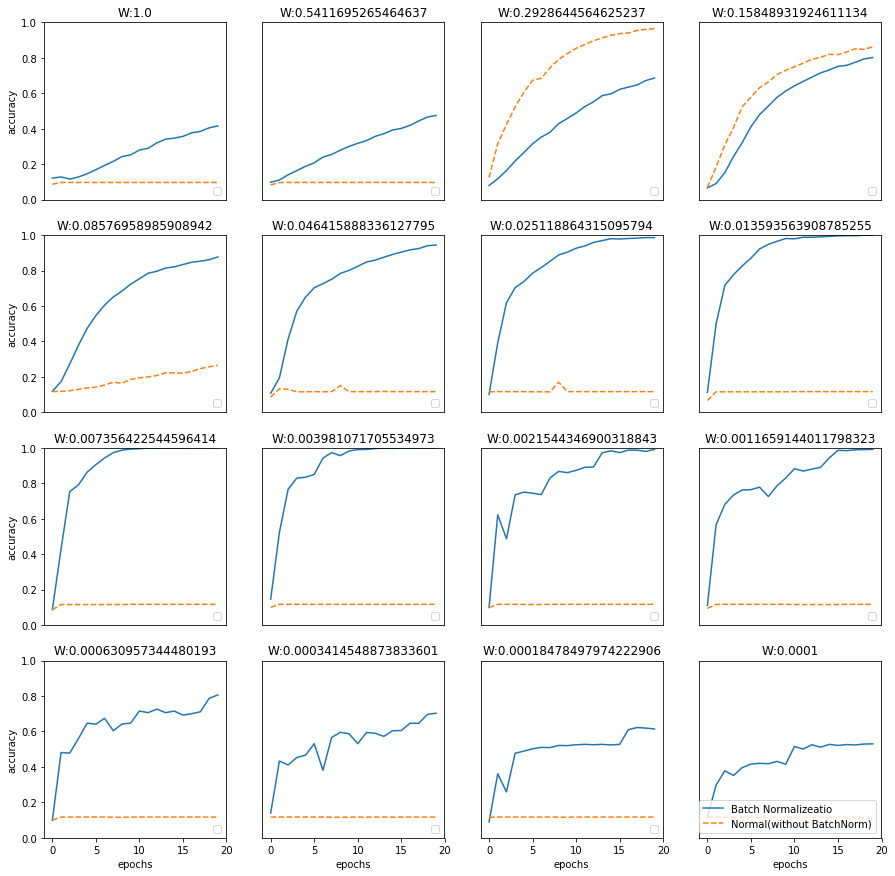

In [17]:
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(15,15))
for i, w in enumerate(weight_scale_list):
    print('==========' + str(i+1) + '/16' + '==========')
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4, 4, i+1)
    plt.title('W:' + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalizeatio', markevery=2)
        plt.plot(x, train_acc_list, linestyle='--', label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle='--', markevery=2)
        
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel('accuracy')
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel('epochs')
    plt.legend(loc='lower right')
plt.show()

# 하이퍼 파라미터 최적화 구하기
> 최적화의 핵심은 하이퍼파라미터의 '최적값'이 존재하는 범위를 조금씩 줄여간다는 것.<br>
대략적인 범위를 설정하고 그 범위에서 무작위로 값을 샘플링 후 그 값으로 정확도를 평가한다.


## MNIST 데이터셋을 사용하여 학습진도 차이를 확인한다.

In [18]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

## 데이터를 불러와서 테스트용으로 데이터 양을 줄인다

In [19]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

In [20]:
x_train = x_train[:500]
t_train = t_train[:500]

In [21]:
## MNIST는 검증 데이터가 따로 없다. 훈련 데이터에서 20% 정도를 분리해서 사용할 수 있다.

In [22]:
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [23]:
def __train(lr, weight_decay, epochs=50):
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100 for _ in range(6)],
                            output_size=10,
                            weight_decay_lambda=weight_decay,
    )
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epochs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=True,
    )
    trainer.train()
    
    return trainer.test_acc_list, trainer.train_acc_list

In [24]:
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial): # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    
    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print('val_acc: %.4f | lr: %.4f, weight_decay: %.4f' %
              (val_acc_list[-1], lr, weight_decay)
    )
    
    key = 'lr: %.4f, weight_decay: %.4f' % (lr, weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

train loss:2.4365707250076265
=== epoch:1, train acc:0.0875, test acc:0.08 ===
train loss:2.3902507956736208
train loss:2.448883921107657
train loss:2.3686358343327987
train loss:2.448976428752847
=== epoch:2, train acc:0.0875, test acc:0.08 ===
train loss:2.4170950222483003
train loss:2.4724664175570923
train loss:2.3500288830170026
train loss:2.396781791798814
=== epoch:3, train acc:0.0875, test acc:0.08 ===
train loss:2.3847794227732253
train loss:2.41610870156877
train loss:2.389676565094848
train loss:2.418703011598976
=== epoch:4, train acc:0.0875, test acc:0.08 ===
train loss:2.4472413990253292
train loss:2.3878673626134153
train loss:2.440406805341973
train loss:2.4251953054899946
=== epoch:5, train acc:0.085, test acc:0.08 ===
train loss:2.4133160767870154
train loss:2.412109984400908
train loss:2.5438161194603426
train loss:2.3200981219707955
=== epoch:6, train acc:0.085, test acc:0.08 ===
train loss:2.4705072182795393
train loss:2.4465503033469584
train loss:2.38889206541623

train loss:2.4174363330494857
=== epoch:1, train acc:0.0975, test acc:0.2 ===
train loss:2.4458500327970585
train loss:2.4682183530754216
train loss:2.502223588078713
train loss:2.566430735367473
=== epoch:2, train acc:0.0975, test acc:0.2 ===
train loss:2.5031767893975028
train loss:2.430496930256888
train loss:2.471989946772015
train loss:2.5487778967081756
=== epoch:3, train acc:0.0975, test acc:0.2 ===
train loss:2.4388382257856187
train loss:2.507690704495185
train loss:2.41789627432079
train loss:2.49001272660275
=== epoch:4, train acc:0.0975, test acc:0.2 ===
train loss:2.470507379889822
train loss:2.561162961476489
train loss:2.4449711120316224
train loss:2.380190576161172
=== epoch:5, train acc:0.0975, test acc:0.2 ===
train loss:2.4610246929944037
train loss:2.5097753624451844
train loss:2.526759477535059
train loss:2.481339018728299
=== epoch:6, train acc:0.0975, test acc:0.2 ===
train loss:2.45586700750805
train loss:2.407009384369929
train loss:2.47541988454887
train loss:

train loss:2.325442010318178
=== epoch:2, train acc:0.065, test acc:0.06 ===
train loss:2.31275933765995
train loss:2.3444534311959964
train loss:2.3669334720787814
train loss:2.328110229193937
=== epoch:3, train acc:0.065, test acc:0.06 ===
train loss:2.3081837689466087
train loss:2.3403596379656517
train loss:2.3557199869367165
train loss:2.332121879766479
=== epoch:4, train acc:0.065, test acc:0.06 ===
train loss:2.347106561975337
train loss:2.3663611020206345
train loss:2.3348267237988147
train loss:2.3091977674261708
=== epoch:5, train acc:0.065, test acc:0.06 ===
train loss:2.3168898449782565
train loss:2.344189987573877
train loss:2.3252779213451724
train loss:2.3905066607881182
=== epoch:6, train acc:0.065, test acc:0.06 ===
train loss:2.3361386091603444
train loss:2.337034763794825
train loss:2.3741642258304
train loss:2.3520858507211546
=== epoch:7, train acc:0.065, test acc:0.06 ===
train loss:2.2848539998943354
train loss:2.313371115810347
train loss:2.365674047133244
train

train loss:2.345381950569681
train loss:2.3554320197657064
train loss:2.360649287586213
train loss:2.3806734821682007
=== epoch:2, train acc:0.115, test acc:0.1 ===
train loss:2.3605598846512152
train loss:2.298748750851142
train loss:2.306416002755872
train loss:2.370457984466565
=== epoch:3, train acc:0.115, test acc:0.1 ===
train loss:2.337690864972702
train loss:2.270210870520178
train loss:2.2408392549265654
train loss:2.302911960982414
=== epoch:4, train acc:0.13, test acc:0.11 ===
train loss:2.300458597132948
train loss:2.316008894870868
train loss:2.2864367126133853
train loss:2.2856464757678805
=== epoch:5, train acc:0.13, test acc:0.12 ===
train loss:2.2592888103151827
train loss:2.2783207632755085
train loss:2.295640577716044
train loss:2.266399483797215
=== epoch:6, train acc:0.1475, test acc:0.12 ===
train loss:2.230381361953187
train loss:2.275424966466375
train loss:2.260938124562673
train loss:2.2345533108414677
=== epoch:7, train acc:0.1625, test acc:0.13 ===
train los

train loss:2.3900603531525295
train loss:2.404254330729707
train loss:2.3974479439943703
train loss:2.4005786658946224
=== epoch:3, train acc:0.085, test acc:0.07 ===
train loss:2.3794240385309764
train loss:2.4332368170728835
train loss:2.4265264179474086
train loss:2.3994125564091457
=== epoch:4, train acc:0.085, test acc:0.07 ===
train loss:2.3604734075265723
train loss:2.38314117747249
train loss:2.4323403826278245
train loss:2.364448339492337
=== epoch:5, train acc:0.085, test acc:0.07 ===
train loss:2.393236533536691
train loss:2.360521045301672
train loss:2.41240830531813
train loss:2.4065681095579463
=== epoch:6, train acc:0.085, test acc:0.07 ===
train loss:2.4195764517800553
train loss:2.4083609539104085
train loss:2.3857029180722913
train loss:2.3600127936645197
=== epoch:7, train acc:0.085, test acc:0.07 ===
train loss:2.4178510519612684
train loss:2.3803100517171876
train loss:2.41380627206224
train loss:2.413564733620434
=== epoch:8, train acc:0.085, test acc:0.07 ===
tra

=== epoch:1, train acc:0.1025, test acc:0.11 ===
train loss:2.418688776271965
train loss:2.4914009549105707
train loss:2.407563178872346
train loss:2.4473551988290434
=== epoch:2, train acc:0.1025, test acc:0.11 ===
train loss:2.407362125196296
train loss:2.392729469011784
train loss:2.362808882681184
train loss:2.361053898231597
=== epoch:3, train acc:0.1025, test acc:0.11 ===
train loss:2.337757387219916
train loss:2.4231562012466963
train loss:2.4012525517573162
train loss:2.387007712047183
=== epoch:4, train acc:0.1025, test acc:0.11 ===
train loss:2.4293579581924813
train loss:2.3832623567903783
train loss:2.4122848830086694
train loss:2.4299350431542885
=== epoch:5, train acc:0.1025, test acc:0.11 ===
train loss:2.468601789825129
train loss:2.4261741186326464
train loss:2.4479001329792367
train loss:2.391105820019311
=== epoch:6, train acc:0.1025, test acc:0.11 ===
train loss:2.437999497232469
train loss:2.4246961928919317
train loss:2.44251455755261
train loss:2.3311742782760785

train loss:2.491821467600192
train loss:2.3849245637013223
train loss:2.4317882415473924
=== epoch:3, train acc:0.0825, test acc:0.08 ===
train loss:2.4729689605567815
train loss:2.4706638571827746
train loss:2.4684819072726962
train loss:2.4165462661989845
=== epoch:4, train acc:0.0825, test acc:0.08 ===
train loss:2.4375508668442687
train loss:2.4323852801627166
train loss:2.336247611266009
train loss:2.3988571902630555
=== epoch:5, train acc:0.0825, test acc:0.08 ===
train loss:2.4809769067369074
train loss:2.481045298738881
train loss:2.417331971908778
train loss:2.4272511495512337
=== epoch:6, train acc:0.0825, test acc:0.07 ===
train loss:2.4526923524387483
train loss:2.4063765808035793
train loss:2.4675308499190978
train loss:2.479134572087202
=== epoch:7, train acc:0.0825, test acc:0.07 ===
train loss:2.37903326810879
train loss:2.4289955473812244
train loss:2.420444300695944
train loss:2.4824997639114197
=== epoch:8, train acc:0.085, test acc:0.07 ===
train loss:2.495431797363

=== epoch:1, train acc:0.07, test acc:0.12 ===
train loss:2.426873557664094
train loss:2.4135234083432926
train loss:2.323574726530153
train loss:2.3949040107175024
=== epoch:2, train acc:0.07, test acc:0.12 ===
train loss:2.3457693166897333
train loss:2.3381311271871184
train loss:2.3712040891344697
train loss:2.3445333820793595
=== epoch:3, train acc:0.07, test acc:0.12 ===
train loss:2.3561755454993585
train loss:2.3691322745523693
train loss:2.321356620474292
train loss:2.3761961129040032
=== epoch:4, train acc:0.075, test acc:0.15 ===
train loss:2.33200212009334
train loss:2.302685109293504
train loss:2.377946334143758
train loss:2.3427020088921244
=== epoch:5, train acc:0.075, test acc:0.15 ===
train loss:2.3628167707436534
train loss:2.3022883879500835
train loss:2.3107046136152687
train loss:2.256296841213715
=== epoch:6, train acc:0.08, test acc:0.15 ===
train loss:2.287987082262919
train loss:2.351984023863182
train loss:2.3166355874121645
train loss:2.31350785548663
=== epoc

train loss:2.3487017374474815
train loss:2.3835016839539795
=== epoch:2, train acc:0.0825, test acc:0.1 ===
train loss:2.384685592749158
train loss:2.2425437725703183
train loss:2.392424552792421
train loss:2.409192932559415
=== epoch:3, train acc:0.0825, test acc:0.1 ===
train loss:2.330844973569381
train loss:2.3385712569730286
train loss:2.356550795728803
train loss:2.3352531729176693
=== epoch:4, train acc:0.0825, test acc:0.1 ===
train loss:2.3506003944070324
train loss:2.457240554626064
train loss:2.401398449200189
train loss:2.382344918344221
=== epoch:5, train acc:0.0825, test acc:0.1 ===
train loss:2.3247967565285745
train loss:2.4286926310112897
train loss:2.323841918235333
train loss:2.3964109307660366
=== epoch:6, train acc:0.0825, test acc:0.1 ===
train loss:2.4309647586230003
train loss:2.408809954163357
train loss:2.3944946261965505
train loss:2.3807843612039745
=== epoch:7, train acc:0.0825, test acc:0.1 ===
train loss:2.3879685022642123
train loss:2.427488978950502
tra

train loss:2.3763164695690433
train loss:2.3369422786926757
=== epoch:4, train acc:0.0975, test acc:0.09 ===
train loss:2.403674695770827
train loss:2.332611577683008
train loss:2.3078084265211847
train loss:2.3268879883984637
=== epoch:5, train acc:0.0975, test acc:0.09 ===
train loss:2.3150206398794757
train loss:2.344356420467621
train loss:2.31548429467661
train loss:2.325951812716923
=== epoch:6, train acc:0.0975, test acc:0.09 ===
train loss:2.395269399632702
train loss:2.3113556744836625
train loss:2.331607132753598
train loss:2.372629661716564
=== epoch:7, train acc:0.0975, test acc:0.1 ===
train loss:2.3868847252811474
train loss:2.335442360662839
train loss:2.382219963695108
train loss:2.4071399872163264
=== epoch:8, train acc:0.0975, test acc:0.1 ===
train loss:2.389398238990237
train loss:2.3250579019522086
train loss:2.353006687696493
train loss:2.387639104614438
=== epoch:9, train acc:0.0975, test acc:0.1 ===
train loss:2.37782718993504
train loss:2.36265269879362
train l

train loss:2.5507695590514983
=== epoch:6, train acc:0.0975, test acc:0.12 ===
train loss:2.4894224698972187
train loss:2.429879612803287
train loss:2.577706727399156
train loss:2.4779807033194716
=== epoch:7, train acc:0.0975, test acc:0.12 ===
train loss:2.444378176142594
train loss:2.5097354703346895
train loss:2.495047858149948
train loss:2.483267041443331
=== epoch:8, train acc:0.0975, test acc:0.12 ===
train loss:2.5089522660338806
train loss:2.4855881344590127
train loss:2.628936727131642
train loss:2.509234570401625
=== epoch:9, train acc:0.0975, test acc:0.12 ===
train loss:2.3880748253390007
train loss:2.6115468384833584
train loss:2.383240528037656
train loss:2.482951961064634
=== epoch:10, train acc:0.0975, test acc:0.12 ===
train loss:2.523010840215073
train loss:2.472355474572874
train loss:2.553886953828679
train loss:2.3838334988261805
=== epoch:11, train acc:0.0975, test acc:0.12 ===
train loss:2.4902972275575785
train loss:2.507052110407309
train loss:2.58115640097877

train loss:2.390340357105969
=== epoch:6, train acc:0.105, test acc:0.07 ===
train loss:2.423225514340734
train loss:2.3576751060483603
train loss:2.29384666234671
train loss:2.346055447703301
=== epoch:7, train acc:0.105, test acc:0.07 ===
train loss:2.352861703202961
train loss:2.4092065390107145
train loss:2.326660415401158
train loss:2.3733951659130637
=== epoch:8, train acc:0.105, test acc:0.07 ===
train loss:2.3565970162354772
train loss:2.3389932799464646
train loss:2.446892825504342
train loss:2.3926788149552705
=== epoch:9, train acc:0.105, test acc:0.07 ===
train loss:2.44664895110946
train loss:2.419723910536724
train loss:2.410113036063241
train loss:2.291118802902761
=== epoch:10, train acc:0.105, test acc:0.07 ===
train loss:2.3779512888972234
train loss:2.358444914299939
train loss:2.3533089858747833
train loss:2.3385658612761904
=== epoch:11, train acc:0.105, test acc:0.07 ===
train loss:2.4103024196299163
train loss:2.360620383028332
train loss:2.3591548849048136
train

train loss:2.368877530635481
train loss:2.2988794605230347
train loss:2.3789569933061214
train loss:2.334029864230644
=== epoch:6, train acc:0.12, test acc:0.19 ===
train loss:2.355916078207246
train loss:2.3564666835809556
train loss:2.30247074215506
train loss:2.357347274462998
=== epoch:7, train acc:0.12, test acc:0.19 ===
train loss:2.3691653915991133
train loss:2.2718479090569748
train loss:2.343836877517685
train loss:2.290012190321703
=== epoch:8, train acc:0.12, test acc:0.19 ===
train loss:2.3232449926093035
train loss:2.325195917684153
train loss:2.3604434762806927
train loss:2.30411394859443
=== epoch:9, train acc:0.12, test acc:0.19 ===
train loss:2.3508984484546707
train loss:2.3354332147068164
train loss:2.385300155931617
train loss:2.346978407260602
=== epoch:10, train acc:0.12, test acc:0.19 ===
train loss:2.3618161737526506
train loss:2.3623797782933584
train loss:2.3470676614409114
train loss:2.2618914319660997
=== epoch:11, train acc:0.12, test acc:0.19 ===
train los

train loss:2.402180920912192
train loss:2.424196704630001
=== epoch:6, train acc:0.1125, test acc:0.09 ===
train loss:2.3868899918856994
train loss:2.379272314522716
train loss:2.446983175875142
train loss:2.435740579906847
=== epoch:7, train acc:0.1125, test acc:0.09 ===
train loss:2.375830006357626
train loss:2.399382779250906
train loss:2.3234975947142003
train loss:2.3791767348569
=== epoch:8, train acc:0.1125, test acc:0.09 ===
train loss:2.399990082293354
train loss:2.44491688758406
train loss:2.366499960869183
train loss:2.4647706599672055
=== epoch:9, train acc:0.1125, test acc:0.09 ===
train loss:2.479902036616867
train loss:2.364934294065801
train loss:2.3865323206459594
train loss:2.3858570554514285
=== epoch:10, train acc:0.1125, test acc:0.09 ===
train loss:2.4562179730805442
train loss:2.429964540015927
train loss:2.4466336584191954
train loss:2.4195410559553783
=== epoch:11, train acc:0.1125, test acc:0.09 ===
train loss:2.383602790632572
train loss:2.4349415756560457
tr

=== epoch:5, train acc:0.11, test acc:0.08 ===
train loss:2.341359295201813
train loss:2.359525524373462
train loss:2.357527478257759
train loss:2.3290950829349524
=== epoch:6, train acc:0.11, test acc:0.08 ===
train loss:2.3626597778990903
train loss:2.2755564522576663
train loss:2.3664224658693125
train loss:2.3624215439945146
=== epoch:7, train acc:0.11, test acc:0.08 ===
train loss:2.32338099385593
train loss:2.2961996808889573
train loss:2.294970066550016
train loss:2.3462450244841784
=== epoch:8, train acc:0.11, test acc:0.08 ===
train loss:2.3470515874752222
train loss:2.295739337809241
train loss:2.352319162348013
train loss:2.2978986106311083
=== epoch:9, train acc:0.11, test acc:0.08 ===
train loss:2.286883088137731
train loss:2.342435054301162
train loss:2.2693080838688333
train loss:2.3117563177065015
=== epoch:10, train acc:0.11, test acc:0.08 ===
train loss:2.3154814850525227
train loss:2.338703356612794
train loss:2.274049524257089
train loss:2.274186677968028
=== epoch:

=== epoch:4, train acc:0.0975, test acc:0.12 ===
train loss:2.3681322392025583
train loss:2.282807990353665
train loss:2.292459729980876
train loss:2.335889747074488
=== epoch:5, train acc:0.0975, test acc:0.12 ===
train loss:2.3351971590787435
train loss:2.381116410851113
train loss:2.3393347721912336
train loss:2.3348839078816632
=== epoch:6, train acc:0.0975, test acc:0.12 ===
train loss:2.4255892853006737
train loss:2.326665929741227
train loss:2.3810686183036265
train loss:2.3248673822598023
=== epoch:7, train acc:0.0975, test acc:0.12 ===
train loss:2.3793196354577124
train loss:2.255084487470251
train loss:2.3655292916196884
train loss:2.24196853008917
=== epoch:8, train acc:0.0975, test acc:0.12 ===
train loss:2.3261699798520166
train loss:2.3754945899437483
train loss:2.3934677787471252
train loss:2.352630970475725
=== epoch:9, train acc:0.0975, test acc:0.12 ===
train loss:2.347137074666891
train loss:2.300746234073244
train loss:2.3290770098783784
train loss:2.36401527961350

train loss:2.5275558960149147
train loss:2.4326854121437185
train loss:2.3906000936807508
train loss:2.452600095598714
=== epoch:4, train acc:0.105, test acc:0.08 ===
train loss:2.3373887194765315
train loss:2.3247623467988694
train loss:2.4640742442214782
train loss:2.49226830417209
=== epoch:5, train acc:0.105, test acc:0.08 ===
train loss:2.3609973329070684
train loss:2.4108158470557703
train loss:2.4527505376193903
train loss:2.4442813607874165
=== epoch:6, train acc:0.105, test acc:0.08 ===
train loss:2.448560627119169
train loss:2.4214162966696846
train loss:2.3965610039233884
train loss:2.4095851494476217
=== epoch:7, train acc:0.105, test acc:0.08 ===
train loss:2.430284096251701
train loss:2.444787459687463
train loss:2.4724704777570534
train loss:2.3960431056592943
=== epoch:8, train acc:0.105, test acc:0.08 ===
train loss:2.4076388025919986
train loss:2.4368097585930353
train loss:2.4468901712081084
train loss:2.4287419836859914
=== epoch:9, train acc:0.105, test acc:0.08 ==

train loss:2.334253058391353
train loss:2.3650501471243848
=== epoch:4, train acc:0.085, test acc:0.12 ===
train loss:2.4273738225059827
train loss:2.463011240494129
train loss:2.407666769037599
train loss:2.3648137543139485
=== epoch:5, train acc:0.085, test acc:0.12 ===
train loss:2.311087651312451
train loss:2.458790580765432
train loss:2.4437688149593386
train loss:2.393316908719323
=== epoch:6, train acc:0.0875, test acc:0.12 ===
train loss:2.413706270144963
train loss:2.345227749445208
train loss:2.4202344317043507
train loss:2.3903643749194865
=== epoch:7, train acc:0.0875, test acc:0.12 ===
train loss:2.4304858772628504
train loss:2.359906193183042
train loss:2.338724279486027
train loss:2.4326642558572185
=== epoch:8, train acc:0.0875, test acc:0.12 ===
train loss:2.414874466359805
train loss:2.4760754888987857
train loss:2.4226649571452685
train loss:2.372714435235446
=== epoch:9, train acc:0.09, test acc:0.12 ===
train loss:2.4087987654734846
train loss:2.432161675643201
tra

train loss:2.4333967315738803
train loss:2.3089858102504963
train loss:2.4912197546125294
train loss:2.39426420445912
=== epoch:6, train acc:0.11, test acc:0.08 ===
train loss:2.2552299433041783
train loss:2.293370400334906
train loss:2.394098194407474
train loss:2.40023042521356
=== epoch:7, train acc:0.11, test acc:0.08 ===
train loss:2.354048181581007
train loss:2.418724839502022
train loss:2.3849474769636974
train loss:2.3326565607639624
=== epoch:8, train acc:0.11, test acc:0.08 ===
train loss:2.42626769212376
train loss:2.441283874264958
train loss:2.3063485502579346
train loss:2.3597217372918036
=== epoch:9, train acc:0.11, test acc:0.08 ===
train loss:2.383808377417324
train loss:2.479229510052093
train loss:2.429871148916682
train loss:2.32334547253536
=== epoch:10, train acc:0.11, test acc:0.08 ===
train loss:2.328705488806328
train loss:2.409907995717865
train loss:2.444417383321809
train loss:2.3837646076047654
=== epoch:11, train acc:0.11, test acc:0.08 ===
train loss:2.44

=== epoch:5, train acc:0.0825, test acc:0.1 ===
train loss:2.4048080538566348
train loss:2.377684162629283
train loss:2.4157927374924646
train loss:2.3872394961983527
=== epoch:6, train acc:0.0825, test acc:0.1 ===
train loss:2.3956582273836964
train loss:2.389718355691363
train loss:2.4279733146872102
train loss:2.4527208218142547
=== epoch:7, train acc:0.0825, test acc:0.1 ===
train loss:2.4381833415253698
train loss:2.456658745033826
train loss:2.437993859126281
train loss:2.4168389918447377
=== epoch:8, train acc:0.0825, test acc:0.1 ===
train loss:2.4164085186633097
train loss:2.3914493095809806
train loss:2.4219155174694538
train loss:2.3979549547775867
=== epoch:9, train acc:0.0825, test acc:0.1 ===
train loss:2.4033216974747864
train loss:2.45669508574182
train loss:2.390988936486732
train loss:2.3605979829068757
=== epoch:10, train acc:0.0825, test acc:0.1 ===
train loss:2.411836259947473
train loss:2.4598660681656375
train loss:2.477382255685984
train loss:2.378189286694523
=

train loss:2.3245884797217755
=== epoch:7, train acc:0.1, test acc:0.1 ===
train loss:2.3769846165141564
train loss:2.47097024889141
train loss:2.350738285407365
train loss:2.395045950173643
=== epoch:8, train acc:0.1, test acc:0.1 ===
train loss:2.357312246205034
train loss:2.3631949169166724
train loss:2.3448160828707647
train loss:2.3626989081272542
=== epoch:9, train acc:0.1, test acc:0.1 ===
train loss:2.3622510664341854
train loss:2.360505504106223
train loss:2.3876978761229237
train loss:2.3593937403057588
=== epoch:10, train acc:0.0975, test acc:0.1 ===
train loss:2.3937402191859474
train loss:2.3444030847460313
train loss:2.344342058243551
train loss:2.389480615987089
=== epoch:11, train acc:0.0975, test acc:0.1 ===
train loss:2.332216273974848
train loss:2.3928338199693253
train loss:2.4077839318360517
train loss:2.3612104016809403
=== epoch:12, train acc:0.0975, test acc:0.1 ===
train loss:2.3751848489402487
train loss:2.310407545525413
train loss:2.3718835741162647
train lo

train loss:2.4456847973757827
train loss:2.4476885280408833
=== epoch:9, train acc:0.06, test acc:0.06 ===
train loss:2.4241070581152897
train loss:2.4654261014688226
train loss:2.519573243551219
train loss:2.409734856566408
=== epoch:10, train acc:0.06, test acc:0.06 ===
train loss:2.44785205013191
train loss:2.5130948660800465
train loss:2.429566122584536
train loss:2.4683824707491984
=== epoch:11, train acc:0.06, test acc:0.06 ===
train loss:2.5461565049041703
train loss:2.568322570259179
train loss:2.5994094430017927
train loss:2.460478003330473
=== epoch:12, train acc:0.06, test acc:0.06 ===
train loss:2.5153162404720995
train loss:2.4700141918490863
train loss:2.5095389006295723
train loss:2.466965454737195
=== epoch:13, train acc:0.06, test acc:0.06 ===
train loss:2.4921046634718835
train loss:2.422164782600011
train loss:2.402093130736884
train loss:2.4986705643931364
=== epoch:14, train acc:0.06, test acc:0.06 ===
train loss:2.426739702796998
train loss:2.559530885262143
train

train loss:2.307963478906958
train loss:2.260232666526471
train loss:2.3115390895525674
train loss:2.318202536371361
=== epoch:9, train acc:0.105, test acc:0.1 ===
train loss:2.2711969625065933
train loss:2.279670348537425
train loss:2.25922295404417
train loss:2.3115794579921682
=== epoch:10, train acc:0.105, test acc:0.1 ===
train loss:2.3175940409980202
train loss:2.325547709809969
train loss:2.297687997247823
train loss:2.2736895385256637
=== epoch:11, train acc:0.105, test acc:0.1 ===
train loss:2.307199221660818
train loss:2.267632289839844
train loss:2.3098909297667976
train loss:2.313605893695011
=== epoch:12, train acc:0.105, test acc:0.1 ===
train loss:2.3021149397904654
train loss:2.325240731355927
train loss:2.2500844160413553
train loss:2.3228880601450657
=== epoch:13, train acc:0.105, test acc:0.1 ===
train loss:2.269778954691167
train loss:2.3112605426279527
train loss:2.290438612217772
train loss:2.293652222802846
=== epoch:14, train acc:0.105, test acc:0.1 ===
train lo

train loss:2.238014026212455
train loss:2.1897032308548288
train loss:2.2013070203438816
=== epoch:8, train acc:0.305, test acc:0.34 ===
train loss:2.196385239423358
train loss:2.190048852279485
train loss:2.151175751307689
train loss:2.132467223249243
=== epoch:9, train acc:0.3125, test acc:0.37 ===
train loss:2.162284661913372
train loss:2.178660085090147
train loss:2.1628397078532795
train loss:2.1729143546787406
=== epoch:10, train acc:0.3225, test acc:0.37 ===
train loss:2.150502336937017
train loss:2.1210630576401144
train loss:2.1592720217324572
train loss:2.176650349604264
=== epoch:11, train acc:0.335, test acc:0.36 ===
train loss:2.136172901249306
train loss:2.116944158945672
train loss:2.1313650806774125
train loss:2.165819781162506
=== epoch:12, train acc:0.35, test acc:0.37 ===
train loss:2.1131992475202583
train loss:2.107898375166741
train loss:2.055644151678122
train loss:2.1235007034618567
=== epoch:13, train acc:0.36, test acc:0.38 ===
train loss:2.1050874708370766
tr

train loss:2.372052846225373
train loss:2.335261234497934
train loss:2.355699895245165
=== epoch:8, train acc:0.0825, test acc:0.05 ===
train loss:2.3533220972756936
train loss:2.340100546927455
train loss:2.3498369627991895
train loss:2.362190475754273
=== epoch:9, train acc:0.0825, test acc:0.05 ===
train loss:2.318804624542815
train loss:2.3484988105699682
train loss:2.327271885429239
train loss:2.377180605711772
=== epoch:10, train acc:0.0825, test acc:0.05 ===
train loss:2.354582083644818
train loss:2.346818056980196
train loss:2.3383130252203954
train loss:2.354144237570273
=== epoch:11, train acc:0.0825, test acc:0.05 ===
train loss:2.351225077918022
train loss:2.2941324072887963
train loss:2.3552009012814152
train loss:2.360061457251646
=== epoch:12, train acc:0.0825, test acc:0.05 ===
train loss:2.3471552861910716
train loss:2.3669558774699504
train loss:2.3689653513421467
train loss:2.299092079086329
=== epoch:13, train acc:0.0825, test acc:0.05 ===
train loss:2.3500691236768

train loss:2.320404498585688
train loss:2.3175168987790444
train loss:2.3355591396419197
=== epoch:8, train acc:0.13, test acc:0.09 ===
train loss:2.3058743637881958
train loss:2.3045298278564994
train loss:2.3300019670641765
train loss:2.338823214094449
=== epoch:9, train acc:0.13, test acc:0.09 ===
train loss:2.295409810415243
train loss:2.3137850946337233
train loss:2.3234552859342172
train loss:2.2887346292165964
=== epoch:10, train acc:0.13, test acc:0.09 ===
train loss:2.341076666481511
train loss:2.2707249766218234
train loss:2.2952941754094867
train loss:2.3186234247547075
=== epoch:11, train acc:0.13, test acc:0.09 ===
train loss:2.2860613056487273
train loss:2.330569250875099
train loss:2.2957756137240235
train loss:2.3480104835181193
=== epoch:12, train acc:0.13, test acc:0.09 ===
train loss:2.266590060926181
train loss:2.346520883770909
train loss:2.3083055047336103
train loss:2.333139058392244
=== epoch:13, train acc:0.13, test acc:0.09 ===
train loss:2.334616049219621
tra

train loss:2.538395957887172
train loss:2.4902246423704253
train loss:2.5414459806181435
=== epoch:8, train acc:0.1075, test acc:0.1 ===
train loss:2.5861777912379935
train loss:2.489302638960712
train loss:2.4623454923346206
train loss:2.5062396018898645
=== epoch:9, train acc:0.1075, test acc:0.1 ===
train loss:2.476415024882053
train loss:2.4945626072893314
train loss:2.5340479581914646
train loss:2.5739974263516716
=== epoch:10, train acc:0.1075, test acc:0.1 ===
train loss:2.6835894144785777
train loss:2.5987648857900303
train loss:2.469469471054985
train loss:2.5303321836490444
=== epoch:11, train acc:0.1075, test acc:0.1 ===
train loss:2.5533629961835844
train loss:2.5557866628596146
train loss:2.561945570049242
train loss:2.489732330363233
=== epoch:12, train acc:0.1075, test acc:0.1 ===
train loss:2.6186906614106884
train loss:2.6187128022838686
train loss:2.5205838238177782
train loss:2.5467008072918524
=== epoch:13, train acc:0.1075, test acc:0.1 ===
train loss:2.56076436966

train loss:2.3892731079773135
train loss:2.3307610381358956
train loss:2.3692720632107034
=== epoch:10, train acc:0.12, test acc:0.08 ===
train loss:2.331931086204033
train loss:2.3233695167489445
train loss:2.41875244500314
train loss:2.3206268651232165
=== epoch:11, train acc:0.1275, test acc:0.08 ===
train loss:2.3280106032185057
train loss:2.3005297983439803
train loss:2.398688553818647
train loss:2.3009600391887277
=== epoch:12, train acc:0.13, test acc:0.08 ===
train loss:2.2322484744964632
train loss:2.334106690528342
train loss:2.3305828463401816
train loss:2.2922832684357113
=== epoch:13, train acc:0.1325, test acc:0.09 ===
train loss:2.3226318967296584
train loss:2.313230064778918
train loss:2.3264518556227993
train loss:2.3376568786396126
=== epoch:14, train acc:0.135, test acc:0.09 ===
train loss:2.306442861808389
train loss:2.2525093427969605
train loss:2.2506944591689044
train loss:2.216357898774805
=== epoch:15, train acc:0.14, test acc:0.09 ===
train loss:2.303698731818

train loss:2.3709595947265023
=== epoch:9, train acc:0.11, test acc:0.08 ===
train loss:2.4974417083449643
train loss:2.5554372923074107
train loss:2.495437850586112
train loss:2.5374771365320608
=== epoch:10, train acc:0.11, test acc:0.08 ===
train loss:2.611114199072814
train loss:2.4503897323159975
train loss:2.4042903848051638
train loss:2.51563191382682
=== epoch:11, train acc:0.11, test acc:0.08 ===
train loss:2.5658413546519387
train loss:2.450710774761748
train loss:2.4833692177213065
train loss:2.5236855422398974
=== epoch:12, train acc:0.11, test acc:0.08 ===
train loss:2.43011581974486
train loss:2.564472858526892
train loss:2.613261165003814
train loss:2.414195112521256
=== epoch:13, train acc:0.11, test acc:0.08 ===
train loss:2.4651376709310955
train loss:2.561127527219494
train loss:2.569118455801278
train loss:2.6146328945626673
=== epoch:14, train acc:0.11, test acc:0.08 ===
train loss:2.6453683657411027
train loss:2.4745754253792662
train loss:2.5984855032941034
train

=== epoch:10, train acc:0.0725, test acc:0.07 ===
train loss:2.3500145709960107
train loss:2.4070217439162436
train loss:2.395688901996333
train loss:2.421674344403509
=== epoch:11, train acc:0.0725, test acc:0.07 ===
train loss:2.3279571882847794
train loss:2.317527374323029
train loss:2.4181879640844803
train loss:2.3654607374462895
=== epoch:12, train acc:0.0725, test acc:0.07 ===
train loss:2.388834164072197
train loss:2.3875418265620114
train loss:2.405633277550907
train loss:2.414517556311715
=== epoch:13, train acc:0.0725, test acc:0.07 ===
train loss:2.417435589185269
train loss:2.430111347842192
train loss:2.4654433143030077
train loss:2.351592886024409
=== epoch:14, train acc:0.0725, test acc:0.07 ===
train loss:2.556725704063258
train loss:2.421677685044388
train loss:2.3725886178581432
train loss:2.3928159156538378
=== epoch:15, train acc:0.0725, test acc:0.07 ===
train loss:2.395455382308387
train loss:2.4454792678336137
train loss:2.517323795794458
train loss:2.3522769369

train loss:2.281758221087054
train loss:2.2642326896300435
=== epoch:12, train acc:0.1725, test acc:0.11 ===
train loss:2.294551867216452
train loss:2.216964718992003
train loss:2.2278687471007155
train loss:2.283928070777906
=== epoch:13, train acc:0.1825, test acc:0.11 ===
train loss:2.2698261094067282
train loss:2.2821640646275836
train loss:2.22078885066176
train loss:2.278653430031137
=== epoch:14, train acc:0.19, test acc:0.11 ===
train loss:2.2166732792756147
train loss:2.303620452147321
train loss:2.2405753410439604
train loss:2.2492492674030373
=== epoch:15, train acc:0.195, test acc:0.11 ===
train loss:2.274343340642406
train loss:2.285027476836923
train loss:2.2437268050135257
train loss:2.271474614174359
=== epoch:16, train acc:0.2025, test acc:0.11 ===
train loss:2.214439057982443
train loss:2.2612908494931947
train loss:2.2909642103060635
train loss:2.192179332127351
=== epoch:17, train acc:0.2075, test acc:0.12 ===
train loss:2.2702413887728463
train loss:2.2412915255832

train loss:2.3304408028882895
train loss:2.4029571899713
train loss:2.33932792178337
=== epoch:11, train acc:0.12, test acc:0.1 ===
train loss:2.3039890990258454
train loss:2.2789344876815143
train loss:2.338022125761878
train loss:2.298127983211237
=== epoch:12, train acc:0.12, test acc:0.1 ===
train loss:2.300403338124548
train loss:2.2967698808215102
train loss:2.337664879359072
train loss:2.312712507520201
=== epoch:13, train acc:0.12, test acc:0.1 ===
train loss:2.3088663604553505
train loss:2.272822931309444
train loss:2.2918151323363225
train loss:2.28466711093437
=== epoch:14, train acc:0.12, test acc:0.1 ===
train loss:2.2742129925047654
train loss:2.2921592350256628
train loss:2.276504414828666
train loss:2.3307021186059633
=== epoch:15, train acc:0.12, test acc:0.1 ===
train loss:2.2761543499782793
train loss:2.245146783191182
train loss:2.380604505305091
train loss:2.2898433281606074
=== epoch:16, train acc:0.12, test acc:0.1 ===
train loss:2.304468247491095
train loss:2.32

=== epoch:13, train acc:0.4, test acc:0.36 ===
train loss:1.8707985985576812
train loss:1.975397706659533
train loss:1.9325925670143775
train loss:1.902106180041775
=== epoch:14, train acc:0.42, test acc:0.37 ===
train loss:1.9389727157496808
train loss:1.850747822614085
train loss:1.9463960840747712
train loss:1.8420998520493415
=== epoch:15, train acc:0.4425, test acc:0.42 ===
train loss:1.8641804298598
train loss:1.7980039888097614
train loss:1.7282141710809957
train loss:1.7699713845238831
=== epoch:16, train acc:0.4825, test acc:0.43 ===
train loss:1.761035965252235
train loss:1.7336013606075193
train loss:1.8584499003092116
train loss:1.8031260187887792
=== epoch:17, train acc:0.49, test acc:0.47 ===
train loss:1.708632530106682
train loss:1.7550047120867625
train loss:1.8053537907221782
train loss:1.7425797019416425
=== epoch:18, train acc:0.5075, test acc:0.5 ===
train loss:1.7292410822333435
train loss:1.7444943792393381
train loss:1.7877401905721235
train loss:1.7550989851377

train loss:2.259398167206915
=== epoch:13, train acc:0.1275, test acc:0.11 ===
train loss:2.23985942906556
train loss:2.281531551495737
train loss:2.250208190697655
train loss:2.210096514494382
=== epoch:14, train acc:0.1325, test acc:0.11 ===
train loss:2.267867747416316
train loss:2.2805207637821043
train loss:2.2161365213385285
train loss:2.2562800322790686
=== epoch:15, train acc:0.1325, test acc:0.11 ===
train loss:2.234081298314652
train loss:2.2494584004163456
train loss:2.1988783823099216
train loss:2.2283093610502367
=== epoch:16, train acc:0.1375, test acc:0.12 ===
train loss:2.2575439928850103
train loss:2.2770818761748033
train loss:2.22194875873565
train loss:2.212779478937693
=== epoch:17, train acc:0.14, test acc:0.12 ===
train loss:2.27255172936992
train loss:2.2734488205793206
train loss:2.280165789629315
train loss:2.2505028828790654
=== epoch:18, train acc:0.1475, test acc:0.13 ===
train loss:2.2540161754323655
train loss:2.1553244308488413
train loss:2.2115263296415

train loss:2.3642227817717596
train loss:2.2103453056062445
train loss:2.399749758160512
train loss:2.344852129638858
=== epoch:12, train acc:0.11, test acc:0.12 ===
train loss:2.3548976651768503
train loss:2.237575309178991
train loss:2.327178190378724
train loss:2.354562124048573
=== epoch:13, train acc:0.11, test acc:0.12 ===
train loss:2.299810202421917
train loss:2.3376628294184485
train loss:2.4006567897606947
train loss:2.2900938335199985
=== epoch:14, train acc:0.1125, test acc:0.12 ===
train loss:2.3908311399725752
train loss:2.326282234059729
train loss:2.386508234803516
train loss:2.353657958223464
=== epoch:15, train acc:0.1175, test acc:0.13 ===
train loss:2.2506046689321426
train loss:2.3401898399662
train loss:2.3590795031038305
train loss:2.2813297050554793
=== epoch:16, train acc:0.1175, test acc:0.13 ===
train loss:2.307012595469476
train loss:2.2916472901505216
train loss:2.276767380860936
train loss:2.3530007009785763
=== epoch:17, train acc:0.1175, test acc:0.13 ==

train loss:2.3655330710832496
=== epoch:11, train acc:0.08, test acc:0.06 ===
train loss:2.438117459966152
train loss:2.3688091380116774
train loss:2.3314780299418607
train loss:2.324580442057852
=== epoch:12, train acc:0.08, test acc:0.06 ===
train loss:2.3561562848955173
train loss:2.368415066033969
train loss:2.3823416185331325
train loss:2.348730120990564
=== epoch:13, train acc:0.08, test acc:0.06 ===
train loss:2.3729267565210184
train loss:2.3648970971374403
train loss:2.4026501680750076
train loss:2.3396922756470215
=== epoch:14, train acc:0.08, test acc:0.06 ===
train loss:2.4589189315243094
train loss:2.3862235639446534
train loss:2.407795704952084
train loss:2.368883025341968
=== epoch:15, train acc:0.08, test acc:0.06 ===
train loss:2.3649490558276236
train loss:2.360091793656424
train loss:2.3417455899062047
train loss:2.2960425416404164
=== epoch:16, train acc:0.08, test acc:0.06 ===
train loss:2.393422318215226
train loss:2.3741860505905854
train loss:2.2568068462087942


train loss:2.467573141464634
=== epoch:10, train acc:0.1125, test acc:0.15 ===
train loss:2.465922545301979
train loss:2.523497999394753
train loss:2.448381901619695
train loss:2.5048120735225567
=== epoch:11, train acc:0.1125, test acc:0.15 ===
train loss:2.4334426205558355
train loss:2.438228451822954
train loss:2.464611942789768
train loss:2.48554551872062
=== epoch:12, train acc:0.1125, test acc:0.15 ===
train loss:2.4625985269780433
train loss:2.4212986782106656
train loss:2.5061284240688946
train loss:2.3886189925281394
=== epoch:13, train acc:0.1125, test acc:0.15 ===
train loss:2.459019567565227
train loss:2.4625592942264305
train loss:2.39653283381646
train loss:2.5069661949513247
=== epoch:14, train acc:0.1125, test acc:0.15 ===
train loss:2.4838963120274786
train loss:2.507580770449272
train loss:2.501737553370632
train loss:2.4687326560410385
=== epoch:15, train acc:0.1125, test acc:0.15 ===
train loss:2.513586499942938
train loss:2.338076250352325
train loss:2.519687867141

train loss:2.275576213275777
train loss:2.2995707588248058
train loss:2.29512740822596
train loss:2.326646859869303
=== epoch:10, train acc:0.1175, test acc:0.06 ===
train loss:2.281097261000624
train loss:2.2402292917190585
train loss:2.3141149315762903
train loss:2.305079277394638
=== epoch:11, train acc:0.1175, test acc:0.06 ===
train loss:2.30887983725004
train loss:2.2844431830636696
train loss:2.3687782675154505
train loss:2.2390506798282743
=== epoch:12, train acc:0.1175, test acc:0.06 ===
train loss:2.3051654458775275
train loss:2.3279834641732617
train loss:2.3477664039256707
train loss:2.294933087697528
=== epoch:13, train acc:0.1175, test acc:0.06 ===
train loss:2.2969315117022218
train loss:2.3062737399029754
train loss:2.295172747654717
train loss:2.234605644586878
=== epoch:14, train acc:0.1175, test acc:0.06 ===
train loss:2.3152155559643592
train loss:2.318484082598269
train loss:2.301032205540399
train loss:2.2780476270029903
=== epoch:15, train acc:0.1175, test acc:0.

train loss:2.409080829339401
train loss:2.404656223035535
train loss:2.384833818610507
=== epoch:10, train acc:0.0975, test acc:0.12 ===
train loss:2.4431639624881
train loss:2.3650595164360606
train loss:2.3527149620678354
train loss:2.357456542752758
=== epoch:11, train acc:0.0975, test acc:0.12 ===
train loss:2.3999863509078763
train loss:2.3682315547017168
train loss:2.3604075292177917
train loss:2.38841221702034
=== epoch:12, train acc:0.0975, test acc:0.12 ===
train loss:2.3509427643500986
train loss:2.3729527884500983
train loss:2.3370672359215248
train loss:2.362881059619374
=== epoch:13, train acc:0.095, test acc:0.12 ===
train loss:2.4360841594762364
train loss:2.3597475061230613
train loss:2.376909181769128
train loss:2.366041521570214
=== epoch:14, train acc:0.0925, test acc:0.12 ===
train loss:2.445187936431079
train loss:2.377189842178983
train loss:2.411409430541835
train loss:2.3924899572935385
=== epoch:15, train acc:0.095, test acc:0.12 ===
train loss:2.34331133643780

train loss:2.4579700550348824
train loss:2.418965144018014
train loss:2.397820116118515
train loss:2.4153146534106624
=== epoch:11, train acc:0.075, test acc:0.06 ===
train loss:2.35981503633095
train loss:2.498807136254576
train loss:2.490088282465439
train loss:2.465720728965997
=== epoch:12, train acc:0.075, test acc:0.06 ===
train loss:2.4818718424644377
train loss:2.4809723352043958
train loss:2.4452695063093035
train loss:2.448419997327797
=== epoch:13, train acc:0.075, test acc:0.06 ===
train loss:2.453665934775622
train loss:2.466587593956788
train loss:2.4302653156584215
train loss:2.4696135936124266
=== epoch:14, train acc:0.075, test acc:0.06 ===
train loss:2.42892377135596
train loss:2.448443999756178
train loss:2.45441417030709
train loss:2.302999276181578
=== epoch:15, train acc:0.075, test acc:0.06 ===
train loss:2.376447853951593
train loss:2.425490609355297
train loss:2.474161743840517
train loss:2.4609892229201873
=== epoch:16, train acc:0.075, test acc:0.06 ===
train

train loss:2.222581698717487
train loss:2.152386923921761
=== epoch:10, train acc:0.22, test acc:0.17 ===
train loss:2.1462640798246246
train loss:2.177129922311693
train loss:2.204280129221161
train loss:2.2406499761876213
=== epoch:11, train acc:0.225, test acc:0.17 ===
train loss:2.2158647916033236
train loss:2.203752864170837
train loss:2.1320305686524232
train loss:2.229894851655743
=== epoch:12, train acc:0.2375, test acc:0.18 ===
train loss:2.2075997182028964
train loss:2.1131609307298715
train loss:2.2559508028261837
train loss:2.196408163395253
=== epoch:13, train acc:0.2375, test acc:0.18 ===
train loss:2.19871184127696
train loss:2.084780400164815
train loss:2.217214854028768
train loss:2.1534727945453085
=== epoch:14, train acc:0.2475, test acc:0.16 ===
train loss:2.170526412937269
train loss:2.172419670609888
train loss:2.1577243899428833
train loss:2.184331336796706
=== epoch:15, train acc:0.25, test acc:0.18 ===
train loss:2.142203639199541
train loss:2.128915879768536
t

train loss:2.4778810449453745
train loss:2.385237428424307
=== epoch:10, train acc:0.1175, test acc:0.1 ===
train loss:2.3857099232965226
train loss:2.3412997840053
train loss:2.369945184508634
train loss:2.4478324665420637
=== epoch:11, train acc:0.1175, test acc:0.1 ===
train loss:2.399153044060499
train loss:2.408983515598033
train loss:2.2961731723433942
train loss:2.3734753827778325
=== epoch:12, train acc:0.1175, test acc:0.1 ===
train loss:2.3817179280173497
train loss:2.2587498867325713
train loss:2.4061014266585987
train loss:2.3189033684691123
=== epoch:13, train acc:0.1175, test acc:0.1 ===
train loss:2.4305589377049768
train loss:2.3937718915896977
train loss:2.329614028794413
train loss:2.3727455027903455
=== epoch:14, train acc:0.1175, test acc:0.1 ===
train loss:2.3806248223820083
train loss:2.3949036277539033
train loss:2.3544888354833327
train loss:2.346177235643265
=== epoch:15, train acc:0.1175, test acc:0.1 ===
train loss:2.312177778138255
train loss:2.3616762093340

train loss:2.296792750566866
train loss:2.332086871962623
train loss:2.325840616539797
train loss:2.3237112741882924
=== epoch:10, train acc:0.1075, test acc:0.06 ===
train loss:2.2490192870461536
train loss:2.2988350301271545
train loss:2.366746777156823
train loss:2.3270166979530837
=== epoch:11, train acc:0.105, test acc:0.06 ===
train loss:2.3507188516765303
train loss:2.2738964884269124
train loss:2.2636279375408987
train loss:2.3025145471707917
=== epoch:12, train acc:0.1075, test acc:0.07 ===
train loss:2.3520122500773954
train loss:2.214563280603911
train loss:2.3578587942893776
train loss:2.2987119689354967
=== epoch:13, train acc:0.11, test acc:0.07 ===
train loss:2.3302738653247794
train loss:2.3144870099565353
train loss:2.3498555949619377
train loss:2.2908126306689462
=== epoch:14, train acc:0.11, test acc:0.08 ===
train loss:2.2511526022008703
train loss:2.367481632970972
train loss:2.30095581972813
train loss:2.2451943287885263
=== epoch:15, train acc:0.1125, test acc:0.

=== epoch:9, train acc:0.145, test acc:0.25 ===
train loss:2.237423152468528
train loss:2.2639383352099522
train loss:2.2449772505798222
train loss:2.240201843575081
=== epoch:10, train acc:0.1475, test acc:0.27 ===
train loss:2.256313517387439
train loss:2.2597830154953686
train loss:2.2187870022926313
train loss:2.21021139131445
=== epoch:11, train acc:0.155, test acc:0.27 ===
train loss:2.2066416269765936
train loss:2.2295603843759912
train loss:2.2498770671387196
train loss:2.247282420919591
=== epoch:12, train acc:0.1625, test acc:0.27 ===
train loss:2.2273024946938964
train loss:2.228201079255487
train loss:2.205293653731993
train loss:2.224058255415165
=== epoch:13, train acc:0.175, test acc:0.27 ===
train loss:2.2035880544735114
train loss:2.2257644955902167
train loss:2.2382963528163877
train loss:2.2386161351022085
=== epoch:14, train acc:0.1825, test acc:0.26 ===
train loss:2.2606842634033573
train loss:2.2133550660593566
train loss:2.1953299894268707
train loss:2.1934806149

train loss:2.4509702990595996
=== epoch:9, train acc:0.1275, test acc:0.09 ===
train loss:2.3944371152781923
train loss:2.332409388480102
train loss:2.4368249432197966
train loss:2.4584507508370317
=== epoch:10, train acc:0.1275, test acc:0.09 ===
train loss:2.3479409964122517
train loss:2.3394000628776257
train loss:2.3582391434895427
train loss:2.3894238790944224
=== epoch:11, train acc:0.1275, test acc:0.08 ===
train loss:2.377300843928915
train loss:2.362008785755569
train loss:2.3384740263205743
train loss:2.3823950443679682
=== epoch:12, train acc:0.1275, test acc:0.08 ===
train loss:2.4455113591426665
train loss:2.3622874872580377
train loss:2.3902967520430543
train loss:2.3412844434156113
=== epoch:13, train acc:0.1275, test acc:0.08 ===
train loss:2.321369239868904
train loss:2.376121942866079
train loss:2.3475233055478295
train loss:2.384099409371293
=== epoch:14, train acc:0.1275, test acc:0.08 ===
train loss:2.3454455021550427
train loss:2.342783380878349
train loss:2.38867

train loss:2.349220387662653
train loss:2.362837293780658
=== epoch:8, train acc:0.1425, test acc:0.15 ===
train loss:2.408511991333246
train loss:2.376513617119029
train loss:2.374839279112973
train loss:2.416170876465534
=== epoch:9, train acc:0.1425, test acc:0.15 ===
train loss:2.2917935761236916
train loss:2.4110972327748437
train loss:2.4055269442659903
train loss:2.365206866577499
=== epoch:10, train acc:0.1425, test acc:0.15 ===
train loss:2.3558968080054563
train loss:2.44531725943114
train loss:2.354315273828098
train loss:2.3068846306615445
=== epoch:11, train acc:0.1425, test acc:0.15 ===
train loss:2.420853935149943
train loss:2.402010414881868
train loss:2.3073571812265303
train loss:2.384422118775578
=== epoch:12, train acc:0.1425, test acc:0.15 ===
train loss:2.2835759782619394
train loss:2.363884221153325
train loss:2.3328927862751834
train loss:2.401744063322882
=== epoch:13, train acc:0.1425, test acc:0.15 ===
train loss:2.358564215811912
train loss:2.382551524390205

train loss:2.3987110114579084
=== epoch:8, train acc:0.0975, test acc:0.09 ===
train loss:2.351854990183121
train loss:2.3093813697946532
train loss:2.3103927359096987
train loss:2.408069249262665
=== epoch:9, train acc:0.0975, test acc:0.09 ===
train loss:2.422503976306323
train loss:2.3720355421843333
train loss:2.4195811435814383
train loss:2.3648143324576663
=== epoch:10, train acc:0.0975, test acc:0.09 ===
train loss:2.403573352966388
train loss:2.4679302870368516
train loss:2.3253576968069147
train loss:2.4299655058298586
=== epoch:11, train acc:0.0975, test acc:0.09 ===
train loss:2.352929568509325
train loss:2.39821843351515
train loss:2.4113577311337213
train loss:2.3603367949214715
=== epoch:12, train acc:0.0975, test acc:0.09 ===
train loss:2.3859068597422364
train loss:2.3587430417343076
train loss:2.4268176736265437
train loss:2.373263165390028
=== epoch:13, train acc:0.0975, test acc:0.09 ===
train loss:2.4120398348904715
train loss:2.4038591051729283
train loss:2.3635575

train loss:2.094258957519064
train loss:2.1256162037289474
train loss:2.0614933363684402
=== epoch:8, train acc:0.3125, test acc:0.29 ===
train loss:2.069802215177349
train loss:2.0549224370112773
train loss:2.0655010081386225
train loss:2.0470677428196224
=== epoch:9, train acc:0.345, test acc:0.31 ===
train loss:2.0428033899870703
train loss:2.0276327828808065
train loss:1.9840837097898762
train loss:2.036628039986888
=== epoch:10, train acc:0.355, test acc:0.33 ===
train loss:2.0119973273006226
train loss:1.9871172545686986
train loss:2.009242968741268
train loss:1.9465006262093374
=== epoch:11, train acc:0.3825, test acc:0.37 ===
train loss:1.9678476912906449
train loss:1.9456187758504888
train loss:1.9243479907683883
train loss:1.9224252699188296
=== epoch:12, train acc:0.425, test acc:0.37 ===
train loss:1.960858250369716
train loss:1.9035591299470027
train loss:1.9191299597363363
train loss:1.869945671498863
=== epoch:13, train acc:0.44, test acc:0.38 ===
train loss:1.9293314867

train loss:2.3800660988480464
train loss:2.4493531326405065
=== epoch:8, train acc:0.1175, test acc:0.2 ===
train loss:2.3946732987954515
train loss:2.5194078437599314
train loss:2.326353964560171
train loss:2.4198593467755884
=== epoch:9, train acc:0.1175, test acc:0.2 ===
train loss:2.486192747645258
train loss:2.4644828112727497
train loss:2.347223232366146
train loss:2.3633944216506344
=== epoch:10, train acc:0.1175, test acc:0.2 ===
train loss:2.378016941673876
train loss:2.4411155804101887
train loss:2.365401780758408
train loss:2.495939661310412
=== epoch:11, train acc:0.1175, test acc:0.2 ===
train loss:2.4452351434245916
train loss:2.4191046885435945
train loss:2.3924231988559033
train loss:2.306447130197246
=== epoch:12, train acc:0.1175, test acc:0.2 ===
train loss:2.4613204104175406
train loss:2.4159207745357105
train loss:2.4435808609978142
train loss:2.430548271699587
=== epoch:13, train acc:0.1175, test acc:0.2 ===
train loss:2.3944616233698826
train loss:2.3819668294083

=== epoch:7, train acc:0.115, test acc:0.07 ===
train loss:2.357484009226006
train loss:2.3414575055209657
train loss:2.511608009560709
train loss:2.436964862443465
=== epoch:8, train acc:0.115, test acc:0.07 ===
train loss:2.4441460002702695
train loss:2.402661369413137
train loss:2.4412293428209457
train loss:2.33344018197751
=== epoch:9, train acc:0.115, test acc:0.07 ===
train loss:2.398478134374765
train loss:2.3507628644947927
train loss:2.5053671735030174
train loss:2.4118523642544174
=== epoch:10, train acc:0.115, test acc:0.07 ===
train loss:2.3741886492575768
train loss:2.3826191949447493
train loss:2.383391847567505
train loss:2.3871886313086597
=== epoch:11, train acc:0.115, test acc:0.07 ===
train loss:2.433332807445962
train loss:2.387773261280854
train loss:2.401742684081042
train loss:2.4323137765850626
=== epoch:12, train acc:0.115, test acc:0.07 ===
train loss:2.417314765308581
train loss:2.428516804948602
train loss:2.3615488005683662
train loss:2.4263360957690456
==

train loss:2.3526141921821093
train loss:2.333070586905231
=== epoch:6, train acc:0.12, test acc:0.16 ===
train loss:2.3119620549973274
train loss:2.359785696767035
train loss:2.296863813513218
train loss:2.3591581405527027
=== epoch:7, train acc:0.12, test acc:0.16 ===
train loss:2.365008682843856
train loss:2.3045858133957022
train loss:2.3336740702466168
train loss:2.3075517221408433
=== epoch:8, train acc:0.12, test acc:0.16 ===
train loss:2.2864641286897998
train loss:2.2968840816928466
train loss:2.3073407572336047
train loss:2.3479783774384515
=== epoch:9, train acc:0.1225, test acc:0.16 ===
train loss:2.3405969596516156
train loss:2.329008533446122
train loss:2.3233202605187144
train loss:2.334241628707203
=== epoch:10, train acc:0.1225, test acc:0.16 ===
train loss:2.346930628386301
train loss:2.3535195944936786
train loss:2.3313414870000435
train loss:2.3788373438033728
=== epoch:11, train acc:0.1225, test acc:0.16 ===
train loss:2.3277140230615716
train loss:2.33891963301864

train loss:2.3107250457614623
train loss:2.380093676982206
train loss:2.3298733945289407
train loss:2.367185981882082
=== epoch:5, train acc:0.1075, test acc:0.11 ===
train loss:2.279572023303019
train loss:2.396706062884592
train loss:2.287850492007375
train loss:2.298307595887373
=== epoch:6, train acc:0.115, test acc:0.12 ===
train loss:2.2809124940183825
train loss:2.308812392568969
train loss:2.285307796371763
train loss:2.3233369873169627
=== epoch:7, train acc:0.12, test acc:0.13 ===
train loss:2.2868057445972827
train loss:2.2772570947350377
train loss:2.3503788407351207
train loss:2.205511664602214
=== epoch:8, train acc:0.1275, test acc:0.16 ===
train loss:2.3419393161796065
train loss:2.2583272002035284
train loss:2.2752519047092474
train loss:2.3160516237622906
=== epoch:9, train acc:0.1375, test acc:0.17 ===
train loss:2.2803262389564916
train loss:2.220700362695974
train loss:2.260942325650671
train loss:2.236404656133887
=== epoch:10, train acc:0.145, test acc:0.17 ===
t

train loss:2.353203978393981
train loss:2.3403854066211545
=== epoch:6, train acc:0.105, test acc:0.07 ===
train loss:2.3075890415340377
train loss:2.294553266300306
train loss:2.333814321914761
train loss:2.3736837135400024
=== epoch:7, train acc:0.1075, test acc:0.07 ===
train loss:2.350788593138722
train loss:2.328132949469567
train loss:2.372259582842582
train loss:2.3640924440734707
=== epoch:8, train acc:0.1075, test acc:0.07 ===
train loss:2.3619869714137818
train loss:2.314466097010364
train loss:2.2949869491066037
train loss:2.3140862571449405
=== epoch:9, train acc:0.11, test acc:0.08 ===
train loss:2.310503768303705
train loss:2.3270354149992616
train loss:2.2900278370432474
train loss:2.3235566559344143
=== epoch:10, train acc:0.1175, test acc:0.08 ===
train loss:2.3035541343314465
train loss:2.268053923400628
train loss:2.3183758292628287
train loss:2.2795413915479434
=== epoch:11, train acc:0.1175, test acc:0.08 ===
train loss:2.3280500460698836
train loss:2.2743205520546

=== epoch:6, train acc:0.0925, test acc:0.1 ===
train loss:2.383086699889092
train loss:2.3791357779111144
train loss:2.419926109174264
train loss:2.4461683055135945
=== epoch:7, train acc:0.0925, test acc:0.1 ===
train loss:2.405622902064675
train loss:2.391582763350129
train loss:2.4051614734493265
train loss:2.386138667533659
=== epoch:8, train acc:0.0925, test acc:0.1 ===
train loss:2.403916984243252
train loss:2.418267035580605
train loss:2.442293041459218
train loss:2.4068620912446153
=== epoch:9, train acc:0.0925, test acc:0.1 ===
train loss:2.394391283100322
train loss:2.4223841225219274
train loss:2.434454796418606
train loss:2.4594576306383864
=== epoch:10, train acc:0.0925, test acc:0.1 ===
train loss:2.4546503598253238
train loss:2.395122001647204
train loss:2.4263926502629536
train loss:2.4542974108304842
=== epoch:11, train acc:0.0925, test acc:0.1 ===
train loss:2.385460059171553
train loss:2.441887300666438
train loss:2.4275457293818636
train loss:2.3628326885272886
===

train loss:2.3521867123957807
=== epoch:5, train acc:0.0875, test acc:0.09 ===
train loss:2.3537039862887297
train loss:2.304083510952786
train loss:2.346665105651925
train loss:2.387543849651156
=== epoch:6, train acc:0.0875, test acc:0.09 ===
train loss:2.335971470773144
train loss:2.407583911065041
train loss:2.441336265813399
train loss:2.4493304148875654
=== epoch:7, train acc:0.0875, test acc:0.09 ===
train loss:2.425099807424918
train loss:2.328121817875793
train loss:2.370046419330175
train loss:2.378380799461438
=== epoch:8, train acc:0.085, test acc:0.09 ===
train loss:2.4028141365745688
train loss:2.438472855178422
train loss:2.3641460889048123
train loss:2.3768331482333136
=== epoch:9, train acc:0.085, test acc:0.09 ===
train loss:2.307566218522109
train loss:2.376114715107931
train loss:2.3355500544505836
train loss:2.302967951140566
=== epoch:10, train acc:0.085, test acc:0.09 ===
train loss:2.3819318331534802
train loss:2.456363915154648
train loss:2.416632478322917
trai

train loss:2.3572258301231286
train loss:2.337899345385085
=== epoch:5, train acc:0.0625, test acc:0.07 ===
train loss:2.379536102703022
train loss:2.3688225111851313
train loss:2.3744561419324817
train loss:2.3274182462416135
=== epoch:6, train acc:0.0625, test acc:0.07 ===
train loss:2.3514537406267246
train loss:2.3438056821110185
train loss:2.3290440170447186
train loss:2.3456155421217653
=== epoch:7, train acc:0.0625, test acc:0.07 ===
train loss:2.368312562614771
train loss:2.366671248515194
train loss:2.3549666770746303
train loss:2.3698745345270433
=== epoch:8, train acc:0.06, test acc:0.07 ===
train loss:2.342823403770743
train loss:2.3418712968900084
train loss:2.3345118803578373
train loss:2.344015543398712
=== epoch:9, train acc:0.06, test acc:0.07 ===
train loss:2.340596558045757
train loss:2.321562610706562
train loss:2.325996597343736
train loss:2.3522864976237474
=== epoch:10, train acc:0.06, test acc:0.07 ===
train loss:2.3498104120109873
train loss:2.3555468627704963


train loss:2.379857932638641
=== epoch:4, train acc:0.115, test acc:0.06 ===
train loss:2.359544239967221
train loss:2.359247115683515
train loss:2.406137725317431
train loss:2.379800448618341
=== epoch:5, train acc:0.115, test acc:0.06 ===
train loss:2.346849567464841
train loss:2.3584786162944322
train loss:2.3913119815651425
train loss:2.3458940376989763
=== epoch:6, train acc:0.115, test acc:0.06 ===
train loss:2.36753266880043
train loss:2.338121947668001
train loss:2.370131614070664
train loss:2.3340203713715626
=== epoch:7, train acc:0.115, test acc:0.06 ===
train loss:2.373343575893107
train loss:2.3431089314727283
train loss:2.386097155890164
train loss:2.3579577763261454
=== epoch:8, train acc:0.115, test acc:0.06 ===
train loss:2.35760229736717
train loss:2.3844086533299222
train loss:2.3133205524056235
train loss:2.3718461122337615
=== epoch:9, train acc:0.115, test acc:0.06 ===
train loss:2.4164423330832694
train loss:2.407540743005336
train loss:2.4024025730721257
train l

train loss:2.4418885673983017
train loss:2.4823199760844963
train loss:2.4005507462237485
train loss:2.3388543163872826
=== epoch:4, train acc:0.0775, test acc:0.05 ===
train loss:2.4456584143588667
train loss:2.3574497233091707
train loss:2.4106439254389924
train loss:2.403255374098072
=== epoch:5, train acc:0.0775, test acc:0.05 ===
train loss:2.4449626619877614
train loss:2.4070480491608732
train loss:2.4697347233215066
train loss:2.5053480143657465
=== epoch:6, train acc:0.0775, test acc:0.05 ===
train loss:2.375095659724143
train loss:2.3700582280897633
train loss:2.290577046255046
train loss:2.385638594353425
=== epoch:7, train acc:0.08, test acc:0.07 ===
train loss:2.432231246614657
train loss:2.4747902145239764
train loss:2.413907807293462
train loss:2.449602037091113
=== epoch:8, train acc:0.0825, test acc:0.07 ===
train loss:2.317832789953944
train loss:2.3805676886279
train loss:2.402021815337373
train loss:2.543628144685591
=== epoch:9, train acc:0.0825, test acc:0.07 ===
t

train loss:2.6284466699367597
train loss:2.602453953806289
=== epoch:6, train acc:0.08, test acc:0.07 ===
train loss:2.656583241435333
train loss:2.63902496385999
train loss:2.689974301520553
train loss:2.6833835522180465
=== epoch:7, train acc:0.08, test acc:0.07 ===
train loss:2.671502096467065
train loss:2.653349064163756
train loss:2.6008731869796966
train loss:2.6244890441938717
=== epoch:8, train acc:0.08, test acc:0.07 ===
train loss:2.6575157863459986
train loss:2.661042792802835
train loss:2.6894897213428766
train loss:2.661761292309859
=== epoch:9, train acc:0.08, test acc:0.07 ===
train loss:2.7634004212537415
train loss:2.6334962335823517
train loss:2.6597985079980093
train loss:2.644140577585656
=== epoch:10, train acc:0.08, test acc:0.07 ===
train loss:2.700594017790785
train loss:2.5581726146119754
train loss:2.6579213729765887
train loss:2.663356167644945
=== epoch:11, train acc:0.08, test acc:0.07 ===
train loss:2.6057379748791565
train loss:2.5627382175535796
train lo

train loss:2.4956723328478807
train loss:2.5008405027908456
train loss:2.479420185784648
train loss:2.4912746209192944
=== epoch:7, train acc:0.07, test acc:0.12 ===
train loss:2.338637487092539
train loss:2.475419871028378
train loss:2.3432628399238484
train loss:2.477362093888675
=== epoch:8, train acc:0.07, test acc:0.13 ===
train loss:2.288969599699976
train loss:2.46262618817402
train loss:2.368521292875856
train loss:2.418796857320147
=== epoch:9, train acc:0.065, test acc:0.14 ===
train loss:2.48360805246713
train loss:2.373772634566688
train loss:2.349871328900788
train loss:2.403287508617892
=== epoch:10, train acc:0.065, test acc:0.14 ===
train loss:2.4470158116507945
train loss:2.2853882580454425
train loss:2.318135652884751
train loss:2.4106118455838805
=== epoch:11, train acc:0.0625, test acc:0.14 ===
train loss:2.462090045736113
train loss:2.4277543250252718
train loss:2.449958337492935
train loss:2.3557805439123345
=== epoch:12, train acc:0.065, test acc:0.14 ===
train l

train loss:2.396872151573154
train loss:2.427695056037359
train loss:2.3443602328529547
train loss:2.3739349731686588
=== epoch:6, train acc:0.0975, test acc:0.1 ===
train loss:2.4061410808263353
train loss:2.3498224858553765
train loss:2.426317412471872
train loss:2.333530693509324
=== epoch:7, train acc:0.0975, test acc:0.1 ===
train loss:2.301914847571789
train loss:2.374620718563628
train loss:2.3269045984135532
train loss:2.473431914703988
=== epoch:8, train acc:0.0975, test acc:0.1 ===
train loss:2.388254609201894
train loss:2.3453503943570446
train loss:2.36475330352136
train loss:2.3358292745831872
=== epoch:9, train acc:0.0975, test acc:0.1 ===
train loss:2.3389230212263756
train loss:2.337732454842091
train loss:2.3466375822999472
train loss:2.3576045339841363
=== epoch:10, train acc:0.0975, test acc:0.1 ===
train loss:2.4252174345335895
train loss:2.3089072348526627
train loss:2.3181586965185494
train loss:2.3652116178225624
=== epoch:11, train acc:0.0975, test acc:0.1 ===
t

=== epoch:4, train acc:0.075, test acc:0.07 ===
train loss:2.3658998876587294
train loss:2.3555687130790255
train loss:2.3851173115835387
train loss:2.3918402662541185
=== epoch:5, train acc:0.075, test acc:0.07 ===
train loss:2.451394376439206
train loss:2.3408511011152497
train loss:2.4271077785151345
train loss:2.419723467551257
=== epoch:6, train acc:0.075, test acc:0.07 ===
train loss:2.371183708269414
train loss:2.3826296912454947
train loss:2.3889214042751137
train loss:2.3413495813583522
=== epoch:7, train acc:0.075, test acc:0.07 ===
train loss:2.3718089423449635
train loss:2.4083083794313396
train loss:2.4329982348782693
train loss:2.3183527307552643
=== epoch:8, train acc:0.075, test acc:0.07 ===
train loss:2.3418657656577024
train loss:2.3846021099630974
train loss:2.345086738053097
train loss:2.377202672408441
=== epoch:9, train acc:0.075, test acc:0.07 ===
train loss:2.2998743662322805
train loss:2.3877071502043834
train loss:2.3814322442378537
train loss:2.356984044941
=

train loss:2.338068564515632
train loss:2.3677412522583174
train loss:2.333500564908986
train loss:2.2864107919740877
=== epoch:4, train acc:0.1, test acc:0.09 ===
train loss:2.3071399844537854
train loss:2.414257795256616
train loss:2.315775423056926
train loss:2.3603567654947555
=== epoch:5, train acc:0.1075, test acc:0.09 ===
train loss:2.3208563615808013
train loss:2.406316290431085
train loss:2.287842958873184
train loss:2.3403643885405527
=== epoch:6, train acc:0.11, test acc:0.09 ===
train loss:2.3190350927019434
train loss:2.301250414647375
train loss:2.259707959478176
train loss:2.3035708706918365
=== epoch:7, train acc:0.105, test acc:0.1 ===
train loss:2.2878339344452923
train loss:2.247615711062026
train loss:2.2609163889390875
train loss:2.2578412834693053
=== epoch:8, train acc:0.11, test acc:0.11 ===
train loss:2.3431735920919623
train loss:2.2748168984252617
train loss:2.2844686782329395
train loss:2.273143637081301
=== epoch:9, train acc:0.115, test acc:0.12 ===
train 

train loss:2.3411261691836702
train loss:2.3842613680163214
train loss:2.3084799456284597
=== epoch:6, train acc:0.09, test acc:0.11 ===
train loss:2.299783764860287
train loss:2.376237565296057
train loss:2.3485760546512573
train loss:2.265245808323418
=== epoch:7, train acc:0.0875, test acc:0.12 ===
train loss:2.354093576888378
train loss:2.364709908195936
train loss:2.2819977237611466
train loss:2.321566361653335
=== epoch:8, train acc:0.0925, test acc:0.11 ===
train loss:2.32093950571525
train loss:2.329187379044625
train loss:2.283615936534351
train loss:2.2782006361177074
=== epoch:9, train acc:0.0975, test acc:0.12 ===
train loss:2.279134620114777
train loss:2.3502060057192926
train loss:2.269004450128073
train loss:2.307352391559241
=== epoch:10, train acc:0.11, test acc:0.12 ===
train loss:2.331972773092141
train loss:2.3470914357819757
train loss:2.2939679609685077
train loss:2.299133856830931
=== epoch:11, train acc:0.1175, test acc:0.13 ===
train loss:2.273246687081496
trai

train loss:2.403528835265921
train loss:2.465129676113988
train loss:2.4435543978477585
=== epoch:8, train acc:0.0875, test acc:0.07 ===
train loss:2.411731717139995
train loss:2.464377344183364
train loss:2.5534159927266304
train loss:2.54206722924307
=== epoch:9, train acc:0.0875, test acc:0.07 ===
train loss:2.366702235845105
train loss:2.445913414291466
train loss:2.3835010162434833
train loss:2.4177366851722106
=== epoch:10, train acc:0.0875, test acc:0.07 ===
train loss:2.559453244117617
train loss:2.4225549183667443
train loss:2.488810916929132
train loss:2.455220889184162
=== epoch:11, train acc:0.0875, test acc:0.07 ===
train loss:2.4059157674685556
train loss:2.542928704773801
train loss:2.4275811808541397
train loss:2.4515036158758727
=== epoch:12, train acc:0.0875, test acc:0.07 ===
train loss:2.4309416646928956
train loss:2.5630102101549626
train loss:2.516774506988677
train loss:2.380821588165006
=== epoch:13, train acc:0.0875, test acc:0.07 ===
train loss:2.4032293363518

train loss:2.4265366737219036
train loss:2.443459467344755
=== epoch:10, train acc:0.09, test acc:0.09 ===
train loss:2.4442998250704924
train loss:2.457134831268768
train loss:2.437141949293011
train loss:2.4512340884888233
=== epoch:11, train acc:0.09, test acc:0.09 ===
train loss:2.456081213287254
train loss:2.456386778452079
train loss:2.4279234365968674
train loss:2.4244266733136235
=== epoch:12, train acc:0.09, test acc:0.09 ===
train loss:2.5161338644415197
train loss:2.4652561989190995
train loss:2.512577840218408
train loss:2.4153345753243505
=== epoch:13, train acc:0.09, test acc:0.09 ===
train loss:2.436886330856069
train loss:2.418821864622742
train loss:2.4701757954781547
train loss:2.43396836639072
=== epoch:14, train acc:0.09, test acc:0.09 ===
train loss:2.4351091979875914
train loss:2.4104619170852266
train loss:2.41396992214712
train loss:2.506339351538657
=== epoch:15, train acc:0.09, test acc:0.09 ===
train loss:2.427230346948672
train loss:2.4629409766478463
train 

train loss:2.394017760225131
train loss:2.4047847787786054
train loss:2.4526945634851316
=== epoch:11, train acc:0.1125, test acc:0.15 ===
train loss:2.3801283665428272
train loss:2.42268816284678
train loss:2.4569984849309243
train loss:2.435737387297064
=== epoch:12, train acc:0.115, test acc:0.15 ===
train loss:2.33424818698099
train loss:2.367766294170085
train loss:2.4040640872849095
train loss:2.398188973177184
=== epoch:13, train acc:0.115, test acc:0.15 ===
train loss:2.4105321778549773
train loss:2.3654296135141584
train loss:2.395732430677253
train loss:2.407303057094092
=== epoch:14, train acc:0.115, test acc:0.15 ===
train loss:2.389815205638331
train loss:2.4106748385323966
train loss:2.3920265442325697
train loss:2.425090312531643
=== epoch:15, train acc:0.115, test acc:0.15 ===
train loss:2.4409327379995607
train loss:2.4485755420978412
train loss:2.4037896767860465
train loss:2.424111318626407
=== epoch:16, train acc:0.115, test acc:0.15 ===
train loss:2.400555171469473

train loss:2.3606265134831688
train loss:2.394965964196426
train loss:2.515338410445589
train loss:2.4326571333743967
=== epoch:10, train acc:0.12, test acc:0.08 ===
train loss:2.4440102457319046
train loss:2.379218457446599
train loss:2.3862300137407844
train loss:2.4080516001066927
=== epoch:11, train acc:0.1225, test acc:0.08 ===
train loss:2.3904253210228483
train loss:2.3897895261573594
train loss:2.398872921466353
train loss:2.45323879518269
=== epoch:12, train acc:0.125, test acc:0.08 ===
train loss:2.3241213876148628
train loss:2.3340446693684034
train loss:2.310555464413368
train loss:2.3892057205350286
=== epoch:13, train acc:0.125, test acc:0.09 ===
train loss:2.333715685267656
train loss:2.372130791965754
train loss:2.2755860287687892
train loss:2.3380320026220627
=== epoch:14, train acc:0.1275, test acc:0.09 ===
train loss:2.4160557511930976
train loss:2.334366327774349
train loss:2.3187426531536772
train loss:2.4416696266496154
=== epoch:15, train acc:0.1225, test acc:0.1

=== epoch:8, train acc:0.195, test acc:0.15 ===
train loss:2.17366456422065
train loss:2.251460969230112
train loss:2.2489181130489246
train loss:2.2666410064227804
=== epoch:9, train acc:0.2025, test acc:0.16 ===
train loss:2.1936371547491644
train loss:2.2046308068317293
train loss:2.210496289475489
train loss:2.218574485300364
=== epoch:10, train acc:0.21, test acc:0.18 ===
train loss:2.208764809265793
train loss:2.2117361602112187
train loss:2.1397138431218146
train loss:2.2476044794655676
=== epoch:11, train acc:0.2175, test acc:0.18 ===
train loss:2.205976627826758
train loss:2.223511335766147
train loss:2.1792347189781576
train loss:2.183327037947834
=== epoch:12, train acc:0.225, test acc:0.2 ===
train loss:2.175921725382462
train loss:2.16032139663971
train loss:2.184998032777438
train loss:2.147783736910379
=== epoch:13, train acc:0.225, test acc:0.23 ===
train loss:2.178607150773949
train loss:2.222914255849994
train loss:2.1588848329843366
train loss:2.179180558336372
=== e

train loss:2.308685696571935
=== epoch:7, train acc:0.07, test acc:0.05 ===
train loss:2.369436215035983
train loss:2.2758778470421186
train loss:2.3383138627962166
train loss:2.3498259706603117
=== epoch:8, train acc:0.07, test acc:0.05 ===
train loss:2.3048473847530833
train loss:2.3202189539837343
train loss:2.3089636699249207
train loss:2.337660139058265
=== epoch:9, train acc:0.07, test acc:0.05 ===
train loss:2.330377709702037
train loss:2.3301665224752783
train loss:2.3480934145380292
train loss:2.2961444567474407
=== epoch:10, train acc:0.07, test acc:0.05 ===
train loss:2.3604194773588
train loss:2.341207024590255
train loss:2.3327874494756644
train loss:2.3849480670799497
=== epoch:11, train acc:0.07, test acc:0.05 ===
train loss:2.3462926616932163
train loss:2.314457735620617
train loss:2.3182174836605354
train loss:2.2992262208391305
=== epoch:12, train acc:0.07, test acc:0.05 ===
train loss:2.3235958386589246
train loss:2.3456516843371586
train loss:2.316407365074561
train

train loss:2.310586244199973
train loss:2.3547441161005724
train loss:2.438407698733763
train loss:2.3596885251740063
=== epoch:10, train acc:0.125, test acc:0.2 ===
train loss:2.341770441776487
train loss:2.480990984111357
train loss:2.353896755372286
train loss:2.3271828458802664
=== epoch:11, train acc:0.1275, test acc:0.2 ===
train loss:2.307938344399206
train loss:2.4051333439989095
train loss:2.386856808893575
train loss:2.3140309964783943
=== epoch:12, train acc:0.1275, test acc:0.2 ===
train loss:2.2998946960923603
train loss:2.253663543615643
train loss:2.4031752564185203
train loss:2.4314128044420142
=== epoch:13, train acc:0.1275, test acc:0.21 ===
train loss:2.343856687265038
train loss:2.3327778805678796
train loss:2.4184314455989355
train loss:2.3353485918046912
=== epoch:14, train acc:0.125, test acc:0.21 ===
train loss:2.413722741373823
train loss:2.3337450183352577
train loss:2.3845125251216324
train loss:2.3559502032236317
=== epoch:15, train acc:0.125, test acc:0.21 

=== epoch:8, train acc:0.1225, test acc:0.13 ===
train loss:2.361619796131717
train loss:2.373234479700111
train loss:2.2751954319890313
train loss:2.297743617555661
=== epoch:9, train acc:0.1275, test acc:0.13 ===
train loss:2.2748127414041517
train loss:2.31026088953857
train loss:2.300503608280206
train loss:2.3674335653834917
=== epoch:10, train acc:0.1275, test acc:0.13 ===
train loss:2.308765548433597
train loss:2.2791828678331374
train loss:2.28887726673411
train loss:2.3706216910463085
=== epoch:11, train acc:0.1275, test acc:0.13 ===
train loss:2.3016332582393817
train loss:2.307755339671201
train loss:2.2786465954219475
train loss:2.343269575137763
=== epoch:12, train acc:0.1275, test acc:0.13 ===
train loss:2.338219261431139
train loss:2.3334719058323747
train loss:2.3093567434902313
train loss:2.3675256886562317
=== epoch:13, train acc:0.1275, test acc:0.13 ===
train loss:2.384812652257056
train loss:2.2880184206349994
train loss:2.3419749791742706
train loss:2.347743202481

=== epoch:9, train acc:0.12, test acc:0.17 ===
train loss:2.316161028608046
train loss:2.288218354823029
train loss:2.282242629579554
train loss:2.3147693812154477
=== epoch:10, train acc:0.12, test acc:0.18 ===
train loss:2.27885853855989
train loss:2.4047361317358007
train loss:2.3113943677508018
train loss:2.250036819138308
=== epoch:11, train acc:0.1175, test acc:0.18 ===
train loss:2.2522017769919263
train loss:2.344519267162915
train loss:2.277531036459461
train loss:2.3122183084275694
=== epoch:12, train acc:0.1275, test acc:0.18 ===
train loss:2.3385736867931146
train loss:2.24908356908124
train loss:2.2794390672020066
train loss:2.283518050426578
=== epoch:13, train acc:0.1275, test acc:0.18 ===
train loss:2.309381759530619
train loss:2.326207404894953
train loss:2.3247249998857433
train loss:2.245296544442415
=== epoch:14, train acc:0.1325, test acc:0.18 ===
train loss:2.2442114593663574
train loss:2.320305781946985
train loss:2.284301060062632
train loss:2.2717190273640306
=

train loss:2.5732436690891944
train loss:2.68955368526111
train loss:2.710859017964741
=== epoch:11, train acc:0.1, test acc:0.1 ===
train loss:2.683027080726585
train loss:2.699913558941731
train loss:2.582786175567995
train loss:2.527397464603996
=== epoch:12, train acc:0.1, test acc:0.1 ===
train loss:2.629202373259663
train loss:2.7067387010289465
train loss:2.6616540210897046
train loss:2.6381293993128785
=== epoch:13, train acc:0.1, test acc:0.1 ===
train loss:2.702535200724606
train loss:2.6709560002447006
train loss:2.6889738430351233
train loss:2.6433514876670774
=== epoch:14, train acc:0.1, test acc:0.1 ===
train loss:2.655019532345676
train loss:2.662477625477442
train loss:2.57825057312732
train loss:2.76277626700046
=== epoch:15, train acc:0.1, test acc:0.1 ===
train loss:2.7281791462192713
train loss:2.6008706381451074
train loss:2.6585140205139592
train loss:2.558553171659739
=== epoch:16, train acc:0.1, test acc:0.1 ===
train loss:2.5803195307678113
train loss:2.6581929

=== epoch:10, train acc:0.115, test acc:0.08 ===
train loss:2.385410791945576
train loss:2.4221945604608113
train loss:2.3407562592886393
train loss:2.4595689157152902
=== epoch:11, train acc:0.115, test acc:0.08 ===
train loss:2.395669620203523
train loss:2.4252074918347724
train loss:2.4218687788709037
train loss:2.4367282877598524
=== epoch:12, train acc:0.115, test acc:0.08 ===
train loss:2.3299963660416116
train loss:2.454063373708084
train loss:2.477935846742876
train loss:2.393071007667634
=== epoch:13, train acc:0.115, test acc:0.08 ===
train loss:2.450578092429867
train loss:2.413477764200038
train loss:2.4615957923865874
train loss:2.405748296427839
=== epoch:14, train acc:0.115, test acc:0.08 ===
train loss:2.425498488209247
train loss:2.3905817454913545
train loss:2.372016543550231
train loss:2.4234257087653006
=== epoch:15, train acc:0.115, test acc:0.08 ===
train loss:2.3353459832306
train loss:2.3645757761344557
train loss:2.388152387320765
train loss:2.4684649313026696


train loss:2.386659266721524
train loss:2.323923794776809
train loss:2.345348077144934
=== epoch:10, train acc:0.11, test acc:0.04 ===
train loss:2.369417546061472
train loss:2.31822415805392
train loss:2.3522632476747147
train loss:2.3745831366864563
=== epoch:11, train acc:0.11, test acc:0.04 ===
train loss:2.3693753591542532
train loss:2.3756415469065253
train loss:2.3267023618726927
train loss:2.3069894161962
=== epoch:12, train acc:0.11, test acc:0.04 ===
train loss:2.346881611640238
train loss:2.3719334711553457
train loss:2.3254729862029966
train loss:2.3010222926732014
=== epoch:13, train acc:0.115, test acc:0.04 ===
train loss:2.282781046608937
train loss:2.349400080221897
train loss:2.2895523481618123
train loss:2.3990589049913362
=== epoch:14, train acc:0.12, test acc:0.04 ===
train loss:2.2961236047044555
train loss:2.3008695853315646
train loss:2.3079693008624425
train loss:2.33702752753089
=== epoch:15, train acc:0.1225, test acc:0.04 ===
train loss:2.3621762129160535
tra

train loss:2.3478253295373825
train loss:2.4193669555865487
train loss:2.4646320394891914
train loss:2.392520863528225
=== epoch:9, train acc:0.11, test acc:0.15 ===
train loss:2.4510759907438477
train loss:2.4468681412544893
train loss:2.3634366288918667
train loss:2.435514896798901
=== epoch:10, train acc:0.11, test acc:0.15 ===
train loss:2.5161071955452794
train loss:2.4355131185598244
train loss:2.4291423971674106
train loss:2.4361345260504685
=== epoch:11, train acc:0.11, test acc:0.15 ===
train loss:2.488209365227777
train loss:2.6075405232841393
train loss:2.4343916026698382
train loss:2.456278715391891
=== epoch:12, train acc:0.11, test acc:0.15 ===
train loss:2.4346064159714658
train loss:2.444950344120943
train loss:2.505495547948922
train loss:2.354946912201935
=== epoch:13, train acc:0.11, test acc:0.15 ===
train loss:2.462514815324243
train loss:2.497905673660076
train loss:2.4632872642938746
train loss:2.359551632275615
=== epoch:14, train acc:0.11, test acc:0.15 ===
tra

train loss:2.4357971296018137
train loss:2.400263471848292
train loss:2.4776819122410565
=== epoch:8, train acc:0.09, test acc:0.08 ===
train loss:2.37966544026972
train loss:2.3997685573910528
train loss:2.3884286786378888
train loss:2.361306729858663
=== epoch:9, train acc:0.09, test acc:0.08 ===
train loss:2.4032737221033833
train loss:2.417789527679888
train loss:2.4561678992538667
train loss:2.4838848765344617
=== epoch:10, train acc:0.09, test acc:0.08 ===
train loss:2.452925017119969
train loss:2.339990915345503
train loss:2.4288763007987155
train loss:2.448183966781385
=== epoch:11, train acc:0.09, test acc:0.08 ===
train loss:2.4194668688520284
train loss:2.418982150333961
train loss:2.3996907371380685
train loss:2.4811485054372
=== epoch:12, train acc:0.09, test acc:0.08 ===
train loss:2.4663001875451114
train loss:2.442141900795322
train loss:2.400642649207231
train loss:2.491787146934789
=== epoch:13, train acc:0.09, test acc:0.08 ===
train loss:2.4252514230285014
train los

train loss:2.355148218400644
train loss:2.3336716610742005
=== epoch:7, train acc:0.0425, test acc:0.05 ===
train loss:2.3153188603045236
train loss:2.36471086190414
train loss:2.290683575738571
train loss:2.3186409065515896
=== epoch:8, train acc:0.0475, test acc:0.05 ===
train loss:2.2955856019142438
train loss:2.34192550432339
train loss:2.282689326572121
train loss:2.3085459952744563
=== epoch:9, train acc:0.0525, test acc:0.06 ===
train loss:2.304798394544206
train loss:2.3022772688825364
train loss:2.269191984473397
train loss:2.2946113042863603
=== epoch:10, train acc:0.06, test acc:0.05 ===
train loss:2.3479976406479355
train loss:2.2908269285635563
train loss:2.2979265537637037
train loss:2.322790362200707
=== epoch:11, train acc:0.065, test acc:0.06 ===
train loss:2.2738796100431404
train loss:2.2906338569478173
train loss:2.303316967003881
train loss:2.296970834610667
=== epoch:12, train acc:0.0775, test acc:0.06 ===
train loss:2.2794537903531946
train loss:2.242637626282092

train loss:2.29298303237969
=== epoch:7, train acc:0.115, test acc:0.13 ===
train loss:2.246958055300556
train loss:2.3228922602969395
train loss:2.3206689452699023
train loss:2.341646941667914
=== epoch:8, train acc:0.1175, test acc:0.12 ===
train loss:2.2473512677621112
train loss:2.3179745811902284
train loss:2.303623352937804
train loss:2.2123636948838743
=== epoch:9, train acc:0.1275, test acc:0.12 ===
train loss:2.241578023454
train loss:2.312319181858335
train loss:2.172447406891196
train loss:2.2562865404013843
=== epoch:10, train acc:0.1375, test acc:0.12 ===
train loss:2.228186587376675
train loss:2.2451013991222077
train loss:2.365612753726508
train loss:2.266722365788988
=== epoch:11, train acc:0.14, test acc:0.11 ===
train loss:2.2126337239565923
train loss:2.3555019395197836
train loss:2.286033970874352
train loss:2.200426985350396
=== epoch:12, train acc:0.1475, test acc:0.15 ===
train loss:2.1601897915394455
train loss:2.2478620681020924
train loss:2.1849821314129017
tr

=== epoch:6, train acc:0.0975, test acc:0.13 ===
train loss:2.3762994459865703
train loss:2.3711743254940454
train loss:2.3747550425374016
train loss:2.3767064945807084
=== epoch:7, train acc:0.0975, test acc:0.13 ===
train loss:2.3644287233720465
train loss:2.389061542550989
train loss:2.3754237538795553
train loss:2.3730267444065016
=== epoch:8, train acc:0.0975, test acc:0.13 ===
train loss:2.385628176893182
train loss:2.438923510901036
train loss:2.4144745397904175
train loss:2.3662614321792756
=== epoch:9, train acc:0.095, test acc:0.13 ===
train loss:2.418495176680561
train loss:2.3334907407434415
train loss:2.3976244384349576
train loss:2.334016390343452
=== epoch:10, train acc:0.095, test acc:0.13 ===
train loss:2.4198675039610293
train loss:2.378519738394818
train loss:2.3608199357307957
train loss:2.4191571282497533
=== epoch:11, train acc:0.095, test acc:0.13 ===
train loss:2.400844200029503
train loss:2.400506026159184
train loss:2.401427254192737
train loss:2.3728665520898

train loss:2.295477528432685
=== epoch:5, train acc:0.18, test acc:0.15 ===
train loss:2.209262614443273
train loss:2.2338124194088356
train loss:2.2737950411094614
train loss:2.297986357061518
=== epoch:6, train acc:0.195, test acc:0.16 ===
train loss:2.2482168521241594
train loss:2.309670439111348
train loss:2.195340688216574
train loss:2.222052179784434
=== epoch:7, train acc:0.21, test acc:0.18 ===
train loss:2.222300043408995
train loss:2.2675289726443855
train loss:2.249803200827161
train loss:2.167032598083945
=== epoch:8, train acc:0.2325, test acc:0.21 ===
train loss:2.208204876940672
train loss:2.232547300350492
train loss:2.25082742663503
train loss:2.244788546943425
=== epoch:9, train acc:0.245, test acc:0.22 ===
train loss:2.1936312714028148
train loss:2.1896478359030422
train loss:2.1718060133392023
train loss:2.1560452373408037
=== epoch:10, train acc:0.2525, test acc:0.22 ===
train loss:2.161300269601519
train loss:2.20753423434574
train loss:2.1899884147370807
train lo

train loss:2.2792371272778023
=== epoch:5, train acc:0.105, test acc:0.18 ===
train loss:2.270332901225212
train loss:2.2929135438967005
train loss:2.2872358026643114
train loss:2.291315398714463
=== epoch:6, train acc:0.105, test acc:0.18 ===
train loss:2.294375625103333
train loss:2.287713654491137
train loss:2.331095422023427
train loss:2.3508147599290794
=== epoch:7, train acc:0.105, test acc:0.18 ===
train loss:2.284575815560669
train loss:2.3268296250490272
train loss:2.29349818027089
train loss:2.2742976782840074
=== epoch:8, train acc:0.1, test acc:0.18 ===
train loss:2.234492111302313
train loss:2.3588937600816076
train loss:2.32830865702882
train loss:2.289346492480333
=== epoch:9, train acc:0.1, test acc:0.18 ===
train loss:2.2988334277252727
train loss:2.3311883656065766
train loss:2.264063803262921
train loss:2.29888974565914
=== epoch:10, train acc:0.1, test acc:0.18 ===
train loss:2.3358428588377036
train loss:2.27290822842929
train loss:2.309088753359302
train loss:2.28

train loss:2.3893689700776948
train loss:2.449791527256849
=== epoch:4, train acc:0.105, test acc:0.11 ===
train loss:2.5596190935957575
train loss:2.466067121938383
train loss:2.3623146883915753
train loss:2.4232172534971124
=== epoch:5, train acc:0.105, test acc:0.11 ===
train loss:2.372888629363916
train loss:2.521336329170552
train loss:2.4724591747036286
train loss:2.4387029200570143
=== epoch:6, train acc:0.105, test acc:0.11 ===
train loss:2.474606540335505
train loss:2.459431581543182
train loss:2.4542384375009405
train loss:2.4835631853807176
=== epoch:7, train acc:0.105, test acc:0.11 ===
train loss:2.4141408820144497
train loss:2.427259622738793
train loss:2.4776406971576037
train loss:2.414619622395757
=== epoch:8, train acc:0.105, test acc:0.11 ===
train loss:2.503560487706604
train loss:2.3818383991600167
train loss:2.2846278682409507
train loss:2.498563823427471
=== epoch:9, train acc:0.105, test acc:0.11 ===
train loss:2.457648481400027
train loss:2.40606318445136
train

train loss:2.4398656763489077
train loss:2.3745901375394256
=== epoch:5, train acc:0.1225, test acc:0.12 ===
train loss:2.4067674097088094
train loss:2.41681841390118
train loss:2.4815865374163586
train loss:2.4329443275663176
=== epoch:6, train acc:0.1225, test acc:0.12 ===
train loss:2.3757961353795625
train loss:2.380798312276389
train loss:2.444495861789589
train loss:2.4449534074287693
=== epoch:7, train acc:0.1225, test acc:0.12 ===
train loss:2.4480941931009665
train loss:2.3783616142944966
train loss:2.37340568886327
train loss:2.4136916106552375
=== epoch:8, train acc:0.1225, test acc:0.12 ===
train loss:2.4303833242425528
train loss:2.383397710284476
train loss:2.3281886180517146
train loss:2.3833751552728466
=== epoch:9, train acc:0.1225, test acc:0.12 ===
train loss:2.36855934775117
train loss:2.417850966297029
train loss:2.3524519619509707
train loss:2.4013299950306064
=== epoch:10, train acc:0.1225, test acc:0.12 ===
train loss:2.3183423550155613
train loss:2.339088503498

train loss:2.4447516961390217
train loss:2.418210202794632
=== epoch:7, train acc:0.065, test acc:0.09 ===
train loss:2.4150795262942926
train loss:2.4404216602635715
train loss:2.4625485826237066
train loss:2.392634503143891
=== epoch:8, train acc:0.065, test acc:0.09 ===
train loss:2.474277032025349
train loss:2.433250967290338
train loss:2.3585475013256687
train loss:2.455588634546663
=== epoch:9, train acc:0.065, test acc:0.09 ===
train loss:2.4428221046715706
train loss:2.362630781684501
train loss:2.4286838884198065
train loss:2.3974869132508787
=== epoch:10, train acc:0.065, test acc:0.09 ===
train loss:2.3704716261830217
train loss:2.385683977052483
train loss:2.5213483829825543
train loss:2.417502218494842
=== epoch:11, train acc:0.065, test acc:0.09 ===
train loss:2.372301372743399
train loss:2.44307096104118
train loss:2.470280581846384
train loss:2.4064765971731203
=== epoch:12, train acc:0.065, test acc:0.09 ===
train loss:2.364207460039753
train loss:2.388827888371713
tra

train loss:2.3732524084883826
train loss:2.2831501794094713
=== epoch:7, train acc:0.13, test acc:0.13 ===
train loss:2.265311491319009
train loss:2.3047842465314323
train loss:2.3081617652554924
train loss:2.285449967147823
=== epoch:8, train acc:0.1375, test acc:0.14 ===
train loss:2.28866245735216
train loss:2.3266140737392167
train loss:2.300476684026489
train loss:2.281073454673917
=== epoch:9, train acc:0.145, test acc:0.14 ===
train loss:2.324025281920033
train loss:2.265668762475309
train loss:2.265118410501337
train loss:2.2402106579541794
=== epoch:10, train acc:0.155, test acc:0.15 ===
train loss:2.2514409234782438
train loss:2.2977564328066786
train loss:2.286974928979899
train loss:2.2536724911695067
=== epoch:11, train acc:0.1625, test acc:0.15 ===
train loss:2.2542326840023104
train loss:2.240003858794741
train loss:2.2736202388706155
train loss:2.219688184732269
=== epoch:12, train acc:0.175, test acc:0.17 ===
train loss:2.25749692419194
train loss:2.2024473076688458
tr

train loss:2.469667157852281
=== epoch:6, train acc:0.115, test acc:0.1 ===
train loss:2.4071697031989028
train loss:2.524449757032842
train loss:2.5234112713304695
train loss:2.5160665748819593
=== epoch:7, train acc:0.115, test acc:0.1 ===
train loss:2.4300603446577385
train loss:2.431163743715303
train loss:2.4509528893394097
train loss:2.4186287885977564
=== epoch:8, train acc:0.115, test acc:0.1 ===
train loss:2.4821876888487577
train loss:2.3789019474305197
train loss:2.5070151231766036
train loss:2.4857188926448948
=== epoch:9, train acc:0.115, test acc:0.1 ===
train loss:2.551679708741379
train loss:2.395896417268578
train loss:2.4661834439111905
train loss:2.5186505099529084
=== epoch:10, train acc:0.115, test acc:0.1 ===
train loss:2.4210973129392146
train loss:2.4567549976842207
train loss:2.409347640815737
train loss:2.3612135929927476
=== epoch:11, train acc:0.115, test acc:0.1 ===
train loss:2.3221110597135617
train loss:2.3514563395956456
train loss:2.557198711737124
tra

=== epoch:6, train acc:0.165, test acc:0.15 ===
train loss:2.202365169519708
train loss:2.2317657442579923
train loss:2.2307652865004166
train loss:2.278111735001671
=== epoch:7, train acc:0.1725, test acc:0.15 ===
train loss:2.237454328596717
train loss:2.2130908099035205
train loss:2.185976380330284
train loss:2.2315458198408797
=== epoch:8, train acc:0.1825, test acc:0.18 ===
train loss:2.1881921485247378
train loss:2.2324669382203535
train loss:2.2022799054654763
train loss:2.199565073738347
=== epoch:9, train acc:0.195, test acc:0.18 ===
train loss:2.230541663988998
train loss:2.1552462618768806
train loss:2.2517021785981424
train loss:2.152812225931076
=== epoch:10, train acc:0.1975, test acc:0.18 ===
train loss:2.1424481732806786
train loss:2.1845640021702146
train loss:2.144410846662379
train loss:2.1094539140942348
=== epoch:11, train acc:0.205, test acc:0.19 ===
train loss:2.1207609301146997
train loss:2.145608771408564
train loss:2.1396625986940196
train loss:2.0882167695023

train loss:2.407262682913079
=== epoch:5, train acc:0.1175, test acc:0.2 ===
train loss:2.4607953491978853
train loss:2.4120305511678524
train loss:2.417735576335393
train loss:2.3805190286627185
=== epoch:6, train acc:0.1175, test acc:0.2 ===
train loss:2.4325185193027083
train loss:2.3537964102046
train loss:2.464793113022622
train loss:2.3777412851319784
=== epoch:7, train acc:0.1175, test acc:0.2 ===
train loss:2.421339112947998
train loss:2.4564960036384726
train loss:2.4209167145378196
train loss:2.3280102583428732
=== epoch:8, train acc:0.1175, test acc:0.2 ===
train loss:2.4274482166994837
train loss:2.4322236083626447
train loss:2.389770378674155
train loss:2.409101730122103
=== epoch:9, train acc:0.1175, test acc:0.2 ===
train loss:2.326035267046912
train loss:2.275844971580916
train loss:2.378589537612291
train loss:2.3740944779033955
=== epoch:10, train acc:0.1175, test acc:0.2 ===
train loss:2.402061969923015
train loss:2.4186885278878925
train loss:2.2750936520495335
trai

train loss:2.560658666377005
=== epoch:7, train acc:0.035, test acc:0.04 ===
train loss:2.5484428977318045
train loss:2.5269314555838434
train loss:2.549907045874667
train loss:2.5426507795131648
=== epoch:8, train acc:0.035, test acc:0.04 ===
train loss:2.517035163929942
train loss:2.4683781777356777
train loss:2.513447930157403
train loss:2.5346046850662187
=== epoch:9, train acc:0.035, test acc:0.04 ===
train loss:2.514137488939422
train loss:2.5408920899276755
train loss:2.5304938415230245
train loss:2.4565085435515166
=== epoch:10, train acc:0.035, test acc:0.04 ===
train loss:2.541283232169605
train loss:2.496874025303313
train loss:2.538776961461555
train loss:2.5387373552609693
=== epoch:11, train acc:0.035, test acc:0.04 ===
train loss:2.4815421831859084
train loss:2.4922390440177167
train loss:2.5299902352075376
train loss:2.4979100115545334
=== epoch:12, train acc:0.035, test acc:0.04 ===
train loss:2.502519148578338
train loss:2.533853931720687
train loss:2.5276288129073325

train loss:2.342703380534981
train loss:2.380835127550615
train loss:2.3712956468759274
train loss:2.376679189642081
=== epoch:7, train acc:0.095, test acc:0.09 ===
train loss:2.4129881214235804
train loss:2.4213294401726984
train loss:2.4027887451771983
train loss:2.4275134767059967
=== epoch:8, train acc:0.095, test acc:0.09 ===
train loss:2.366363034836218
train loss:2.358408071745258
train loss:2.4009612519786048
train loss:2.464614390229988
=== epoch:9, train acc:0.095, test acc:0.09 ===
train loss:2.3507551426823854
train loss:2.44514001747723
train loss:2.3709670274025894
train loss:2.442535046000972
=== epoch:10, train acc:0.095, test acc:0.09 ===
train loss:2.3791170896737066
train loss:2.363068471624195
train loss:2.315405846424048
train loss:2.3546456329106085
=== epoch:11, train acc:0.095, test acc:0.09 ===
train loss:2.4387311586326526
train loss:2.3937611407764567
train loss:2.359237520435745
train loss:2.42455710673089
=== epoch:12, train acc:0.095, test acc:0.09 ===
tra

train loss:2.2968168500660453
train loss:2.3351530009660326
=== epoch:6, train acc:0.1, test acc:0.06 ===
train loss:2.3029096053466955
train loss:2.292786066798926
train loss:2.305329260916673
train loss:2.3123077095992572
=== epoch:7, train acc:0.1, test acc:0.04 ===
train loss:2.355403754008028
train loss:2.3429360719230403
train loss:2.309998414451135
train loss:2.3285248357695525
=== epoch:8, train acc:0.105, test acc:0.04 ===
train loss:2.339665320931476
train loss:2.3396937281341046
train loss:2.3051897981722567
train loss:2.3533097256554587
=== epoch:9, train acc:0.105, test acc:0.04 ===
train loss:2.337891639536693
train loss:2.245651049429092
train loss:2.3619942526641227
train loss:2.3457223000029894
=== epoch:10, train acc:0.105, test acc:0.04 ===
train loss:2.323232517366138
train loss:2.326494643952617
train loss:2.24841284536974
train loss:2.2900451756056093
=== epoch:11, train acc:0.1025, test acc:0.04 ===
train loss:2.2682185180416674
train loss:2.298322633453175
train

train loss:2.3423465725263295
train loss:2.3513829521223344
=== epoch:8, train acc:0.0675, test acc:0.03 ===
train loss:2.484076432347116
train loss:2.41587143389337
train loss:2.367610825472223
train loss:2.3641028017637393
=== epoch:9, train acc:0.07, test acc:0.04 ===
train loss:2.3658525373392076
train loss:2.341225055467948
train loss:2.3814991245950785
train loss:2.3514610913684684
=== epoch:10, train acc:0.0675, test acc:0.04 ===
train loss:2.2985017873829374
train loss:2.3025566172344636
train loss:2.3643074318542934
train loss:2.428569649705557
=== epoch:11, train acc:0.0675, test acc:0.04 ===
train loss:2.348421759989573
train loss:2.4077694102680804
train loss:2.3556683712638327
train loss:2.394486284954819
=== epoch:12, train acc:0.0675, test acc:0.04 ===
train loss:2.3877669791074787
train loss:2.3266618262700676
train loss:2.3847734063096593
train loss:2.3483150020617467
=== epoch:13, train acc:0.0675, test acc:0.04 ===
train loss:2.3420210404484747
train loss:2.251356569

train loss:2.5611834932716753
train loss:2.433860345904333
train loss:2.549215317198408
train loss:2.4684302588278046
=== epoch:8, train acc:0.105, test acc:0.11 ===
train loss:2.4603186905548244
train loss:2.4721930002776844
train loss:2.460717776752303
train loss:2.5174877286454076
=== epoch:9, train acc:0.105, test acc:0.11 ===
train loss:2.4823687466159003
train loss:2.4999093782332764
train loss:2.456744614811756
train loss:2.4275249420183114
=== epoch:10, train acc:0.105, test acc:0.11 ===
train loss:2.4236517945334755
train loss:2.551622498520117
train loss:2.4551784894902657
train loss:2.4860487034234806
=== epoch:11, train acc:0.105, test acc:0.11 ===
train loss:2.3717307276216473
train loss:2.5013009679137492
train loss:2.4824304021738803
train loss:2.4710787552641653
=== epoch:12, train acc:0.105, test acc:0.11 ===
train loss:2.4957465493758404
train loss:2.40514971519541
train loss:2.431721392234616
train loss:2.422639636399068
=== epoch:13, train acc:0.105, test acc:0.11 =

=== epoch:7, train acc:0.1225, test acc:0.19 ===
train loss:2.272901681640896
train loss:2.231909397341234
train loss:2.3458773084350346
train loss:2.3595722710014853
=== epoch:8, train acc:0.125, test acc:0.19 ===
train loss:2.339712385282295
train loss:2.3435749633975513
train loss:2.3005135448193186
train loss:2.3077232998409083
=== epoch:9, train acc:0.125, test acc:0.19 ===
train loss:2.2804925058863463
train loss:2.370327219897403
train loss:2.321572296004429
train loss:2.352332668780672
=== epoch:10, train acc:0.125, test acc:0.19 ===
train loss:2.376503449945668
train loss:2.3379251527253957
train loss:2.355802478498976
train loss:2.4435479921164194
=== epoch:11, train acc:0.125, test acc:0.19 ===
train loss:2.282736710076216
train loss:2.3330875608972983
train loss:2.3715222978298485
train loss:2.2924778580683385
=== epoch:12, train acc:0.125, test acc:0.19 ===
train loss:2.2657762991550143
train loss:2.3642436877819946
train loss:2.322188560593622
train loss:2.281850497194793

train loss:2.514968385364944
=== epoch:9, train acc:0.1125, test acc:0.13 ===
train loss:2.624877449017531
train loss:2.5135589432574106
train loss:2.381161829501582
train loss:2.492725140039221
=== epoch:10, train acc:0.1125, test acc:0.13 ===
train loss:2.495025083506465
train loss:2.626715100695072
train loss:2.5416988252734973
train loss:2.48261086884452
=== epoch:11, train acc:0.1125, test acc:0.13 ===
train loss:2.512140713899485
train loss:2.389341581626579
train loss:2.584327920684682
train loss:2.507902168579359
=== epoch:12, train acc:0.1125, test acc:0.13 ===
train loss:2.4474905955414603
train loss:2.602500329579376
train loss:2.5344696145244585
train loss:2.394376600660637
=== epoch:13, train acc:0.1125, test acc:0.13 ===
train loss:2.5464299516855022
train loss:2.542126189727588
train loss:2.520412616749662
train loss:2.550226110332142
=== epoch:14, train acc:0.1125, test acc:0.13 ===
train loss:2.4889312964177313
train loss:2.46713127123773
train loss:2.537816226326605
t

train loss:2.4105637302771603
=== epoch:8, train acc:0.1, test acc:0.08 ===
train loss:2.3746887353683417
train loss:2.322685345536702
train loss:2.3156660820868415
train loss:2.333714485772617
=== epoch:9, train acc:0.1, test acc:0.08 ===
train loss:2.3329455007308666
train loss:2.3411834887471845
train loss:2.275674304307248
train loss:2.3438101098077926
=== epoch:10, train acc:0.1, test acc:0.08 ===
train loss:2.3657901842983535
train loss:2.337582263391357
train loss:2.3641608081718943
train loss:2.372026109388463
=== epoch:11, train acc:0.1, test acc:0.08 ===
train loss:2.36232853815572
train loss:2.355867364948754
train loss:2.3586403117190966
train loss:2.387130311547717
=== epoch:12, train acc:0.1, test acc:0.08 ===
train loss:2.347291134688076
train loss:2.381054125457179
train loss:2.3969556733724127
train loss:2.3621741642141703
=== epoch:13, train acc:0.1, test acc:0.08 ===
train loss:2.4004392513759014
train loss:2.4101306974523675
train loss:2.395778307282478
train loss:2

=== epoch:9, train acc:0.065, test acc:0.09 ===
train loss:2.355498376915837
train loss:2.3051500709218016
train loss:2.3018301980306495
train loss:2.350555871299914
=== epoch:10, train acc:0.065, test acc:0.09 ===
train loss:2.358254790114055
train loss:2.3456994205708415
train loss:2.3259528827601947
train loss:2.303254843300183
=== epoch:11, train acc:0.065, test acc:0.09 ===
train loss:2.3462168255337508
train loss:2.3260544666924523
train loss:2.336775634180918
train loss:2.3173333009722232
=== epoch:12, train acc:0.065, test acc:0.09 ===
train loss:2.3338258968130527
train loss:2.3608755929552303
train loss:2.3355427612063138
train loss:2.369536877641902
=== epoch:13, train acc:0.065, test acc:0.09 ===
train loss:2.326725977522005
train loss:2.335245605121342
train loss:2.3440383506673896
train loss:2.3792939334998318
=== epoch:14, train acc:0.065, test acc:0.09 ===
train loss:2.3162249324920716
train loss:2.3425793968976194
train loss:2.3369693605064383
train loss:2.324143890768

train loss:2.2910829262726997
train loss:2.3007063143116997
=== epoch:8, train acc:0.1625, test acc:0.22 ===
train loss:2.3288091868911414
train loss:2.3000883147904716
train loss:2.2370386799891855
train loss:2.3281944203103686
=== epoch:9, train acc:0.1625, test acc:0.22 ===
train loss:2.2487655846106107
train loss:2.321344423206906
train loss:2.3192016502057036
train loss:2.2976160873978206
=== epoch:10, train acc:0.17, test acc:0.21 ===
train loss:2.3193426247409836
train loss:2.2551756943345693
train loss:2.2587862777173537
train loss:2.273204247208576
=== epoch:11, train acc:0.1725, test acc:0.22 ===
train loss:2.233773258371159
train loss:2.3044861126109883
train loss:2.269433324503876
train loss:2.2698717979459526
=== epoch:12, train acc:0.1725, test acc:0.23 ===
train loss:2.2349878535606913
train loss:2.2508551529457526
train loss:2.2428689432441287
train loss:2.2415986932472793
=== epoch:13, train acc:0.175, test acc:0.23 ===
train loss:2.224682024052698
train loss:2.2222303

========== Hyper-Parameter Optimization Result ==========
Best-1(val acc:0.85) | lr: 0.0073, weight_decay: 0.0000
Best-2(val acc:0.83) | lr: 0.0094, weight_decay: 0.0000
Best-3(val acc:0.79) | lr: 0.0057, weight_decay: 0.0000
Best-4(val acc:0.74) | lr: 0.0058, weight_decay: 0.0000
Best-5(val acc:0.69) | lr: 0.0045, weight_decay: 0.0000
Best-6(val acc:0.62) | lr: 0.0037, weight_decay: 0.0001
Best-7(val acc:0.6) | lr: 0.0033, weight_decay: 0.0000
Best-8(val acc:0.57) | lr: 0.0026, weight_decay: 0.0000
Best-9(val acc:0.52) | lr: 0.0027, weight_decay: 0.0000
Best-10(val acc:0.47) | lr: 0.0031, weight_decay: 0.0000
Best-11(val acc:0.47) | lr: 0.0018, weight_decay: 0.0000
Best-12(val acc:0.43) | lr: 0.0017, weight_decay: 0.0000
Best-13(val acc:0.4) | lr: 0.0024, weight_decay: 0.0000
Best-14(val acc:0.38) | lr: 0.0025, weight_decay: 0.0000
Best-15(val acc:0.37) | lr: 0.0019, weight_decay: 0.0000
Best-16(val acc:0.27) | lr: 0.0008, weight_decay: 0.0000
Best-17(val acc:0.26) | lr: 0.0015, weigh

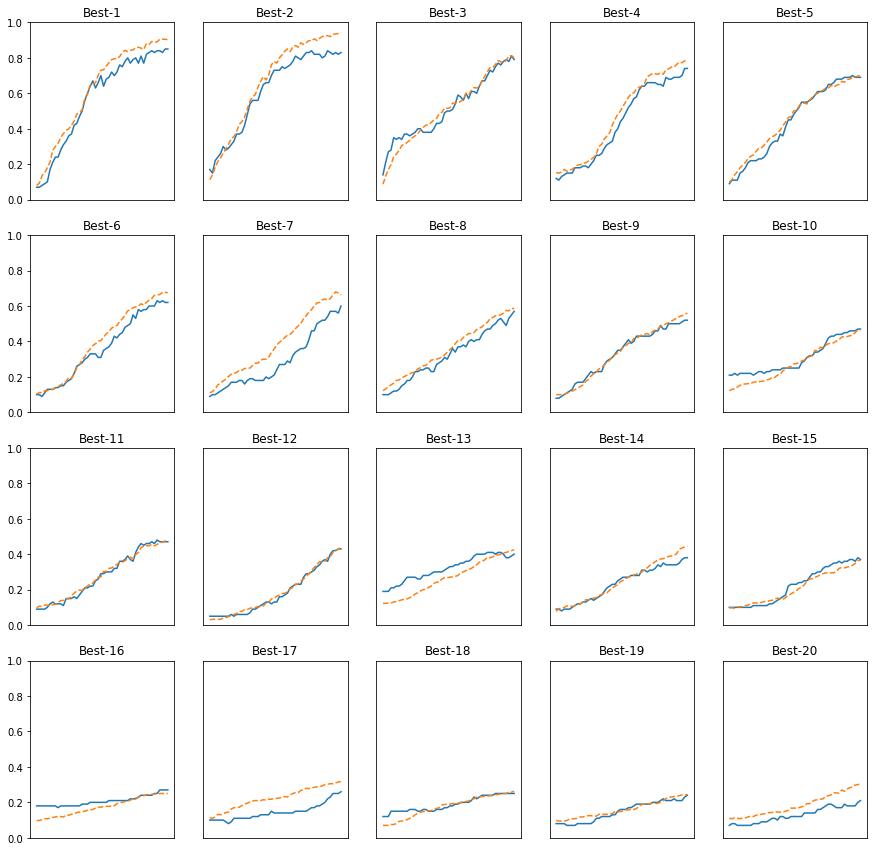

In [25]:
print('========== Hyper-Parameter Optimization Result ==========')
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(15,15))

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print('Best-' + str(i+1) + '(val acc:' + str(val_acc_list[-1]) + ') | ' + key)
    
    plt.subplot(row_num, col_num, i+1)
    plt.title('Best-' + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], '--')
    i += 1
    
    if i >= graph_draw_num:
        break

plt.show()

## 데이터를 불러와서 테스트용으로 데이터 양을 줄인다

In [26]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

## 비교할 4가지 방법을 정의한다.
### 확률적 경사하강법 복습
> SGD는 손실함수의 기울기를 계산하여서 이 기울기 값에 학습률(Learning Rate)를 계산하여 이 결과 값으로 기존의 가중치 값을 갱신한다.
### 모멘텀 Momentum
>  속도가 크게 나올수록 기울기가 크게 업데이트 되어 확률적 경사하강법이 가지는 단점을 보완할 수 있다.
### AdaGrad
> 신경망 학습에서의 학습률 learning rate의 값은 일종의 보폭으로 생각할 수 있는데 한 번 갱신하는 가중치의 값을 양을 결정한다. 
### Adam
> Momentum과 AdaGrad를 섞은 기법이라고 보면 된다.
따라서 하이퍼파라미터도 그만큼 많다. 모멘텀에서 사용하는 계수와 학습률에 대한 계수가 사용된다

In [27]:
import os
import sys
sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

In [28]:
optimizers = {
    'SGD': SGD(),
    'Momentum': Momentum(),
    'AdaGrad': AdaGrad(),
    'Adam': Adam(),
}

## 각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용

In [29]:
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10,
    )
    train_loss[key] = []

## 인식률은 AdaGrad > Adam > Momentum >> SGD 순서였다.

In [30]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print('========== iteration: %d ==========' % i)
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ':' + str(loss))

========== iteration: 0 ==========
SGD:2.3083815106545824
Adam:2.1793509245662497
AdaGrad:2.2038791658482206
Momentum:2.3924964832690403
========== iteration: 100 ==========
SGD:1.3525754089334479
Adam:0.15629034281251913
AdaGrad:0.08555175716287061
Momentum:0.2573192868351295
========== iteration: 200 ==========
SGD:0.8256919055751185
Adam:0.2877176821154616
AdaGrad:0.15401780116578279
Momentum:0.3930400176929182
========== iteration: 300 ==========
SGD:0.45059402040724533
Adam:0.1422206141242559
AdaGrad:0.12026976095730049
Momentum:0.1772373915699958
========== iteration: 400 ==========
SGD:0.35707416872263775
Adam:0.07804369799833927
AdaGrad:0.0853482380646906
Momentum:0.16387721807510994
========== iteration: 500 ==========
SGD:0.4228321790437184
Adam:0.18265202425442517
AdaGrad:0.10310430072425081
Momentum:0.23729653581008422
========== iteration: 600 ==========
SGD:0.36356353845598743
Adam:0.1311267958330596
AdaGrad:0.06184940786711124
Momentum:0.16409075695565284
========== iter

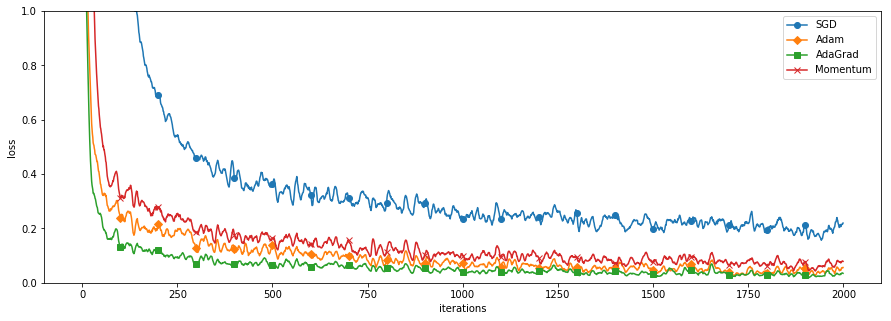

In [31]:
markers = {
    'SGD': 'o',
    'Momentum': 'x',
    'AdaGrad': 's',
    'Adam': 'D',
}
x = np.arange(max_iterations)

plt.figure(figsize=(15,5))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

# 갱신 방법 결정


## Minist 데이터 로드

In [32]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

In [33]:
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0 * y

In [34]:
init_pos = (-7.0, 2.0)
params = {
    'x': init_pos[0],
    'y': init_pos[1],
}
grads = {
    'x': 0,
    'y': 0,
}

## 비교할 4가지 방법을 정의한다.
### 확률적 경사하강법 복습
> SGD는 손실함수의 기울기를 계산하여서 이 기울기 값에 학습률(Learning Rate)를 계산하여 이 결과 값으로 기존의 가중치 값을 갱신한다.
### 모멘텀 Momentum
>  속도가 크게 나올수록 기울기가 크게 업데이트 되어 확률적 경사하강법이 가지는 단점을 보완할 수 있다.
### AdaGrad
> 신경망 학습에서의 학습률 learning rate의 값은 일종의 보폭으로 생각할 수 있는데 한 번 갱신하는 가중치의 값을 양을 결정한다. 
### Adam
> Momentum과 AdaGrad를 섞은 기법이라고 보면 된다.
따라서 하이퍼파라미터도 그만큼 많다. 모멘텀에서 사용하는 계수와 학습률에 대한 계수가 사용된다

In [35]:
optimizers = OrderedDict()
optimizers['SGD'] = SGD(lr=0.95)
optimizers['Momentum'] = Momentum(lr=0.1)
optimizers['AdaGrad'] = AdaGrad(lr=1.5)
optimizers['Adam'] = Adam(lr=0.3)

## 하이퍼 파라미터를 어떻게 설정하느냐에 따라서 결과가 달라진다 
> 문제에 따라 기법을 다르게 써야한다

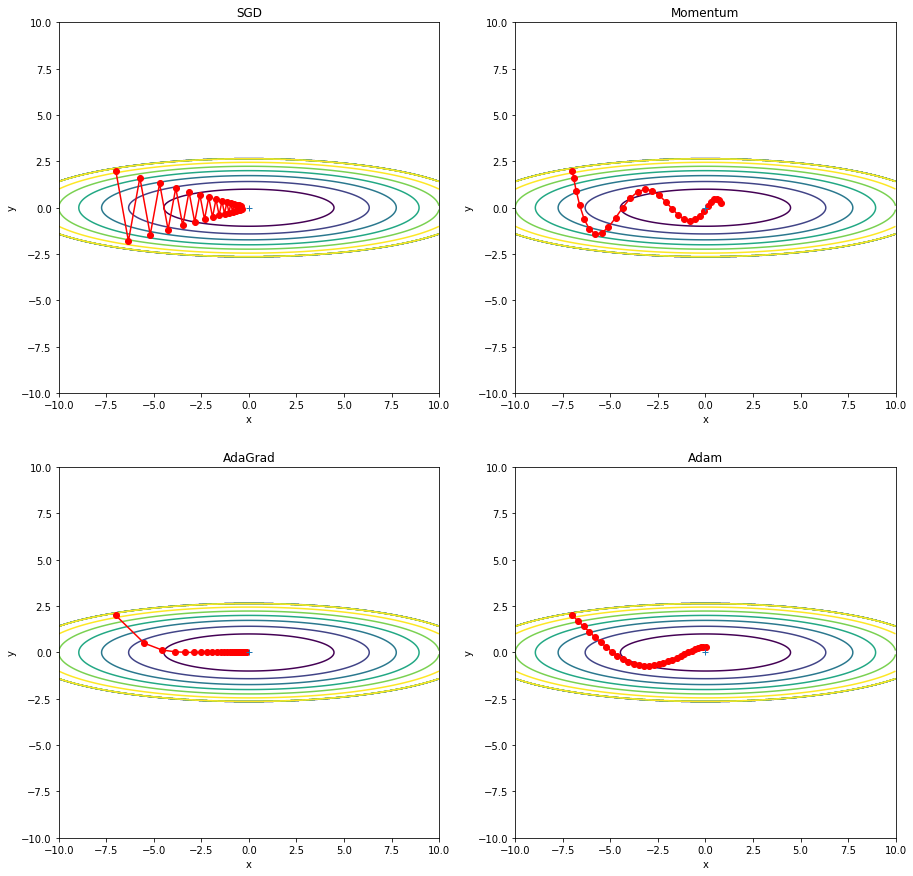

In [36]:
idx = 1
plt.figure(figsize=(15,15))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
        
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    mask = Z > 7
    Z[mask] = 0
    
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color='red')
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    
    plt.title(key)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()

<img src ='최적화.png'  > 

# Drop out

In [37]:
from layer_naive import *

In [38]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend # common 패키지에 있는 다중 퍼셉트론 넷 구현 위한 함수 불러오기
from common.trainer import Trainer

In [39]:
# 오버피팅재현위해 학습데이터수 줄이기
(x_train, t_train), (x_test, t_test) = load_mnist()
x_train = x_train[:300]
t_train = t_train[:300]

In [40]:
# 드롭아웃 사용할지 안할지 유무 적용
use_dropout = True

# 0.2 
dropout_ratio = 0.2

# 네트워크~ 사이즈 조정 후 히든 사이즈를 주고 아웃풋도 줌

# 여러가지의 파라미터가 있는데 드랍 아웃 사용 하고 
# 죽여버릴 비율을 한 iteration 당 0.2로 줌
network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100 for _ in range(6)],
                              output_size=10,
                              use_dropout=use_dropout,
                              dropout_ration=dropout_ratio,
)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True
)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

train loss:2.319638933801686
=== epoch:1, train acc:0.14, test acc:0.1282 ===
train loss:2.3056278727398416
train loss:2.3051466711308435
train loss:2.3095865277064704
=== epoch:2, train acc:0.15, test acc:0.1351 ===
train loss:2.2931091550450087
train loss:2.3014704303997884
train loss:2.3101429066590313
=== epoch:3, train acc:0.15333333333333332, test acc:0.1404 ===
train loss:2.2989443132356104
train loss:2.297113843800268
train loss:2.302671911314375
=== epoch:4, train acc:0.15666666666666668, test acc:0.147 ===
train loss:2.32515257313899
train loss:2.2960222460655695
train loss:2.3006369506699684
=== epoch:5, train acc:0.15666666666666668, test acc:0.1494 ===
train loss:2.297166618772762
train loss:2.3186176927613658
train loss:2.299913254179164
=== epoch:6, train acc:0.15333333333333332, test acc:0.1518 ===
train loss:2.2991826208312864
train loss:2.2983822070573656
train loss:2.2906172297324976
=== epoch:7, train acc:0.15333333333333332, test acc:0.1541 ===
train loss:2.3003194

=== epoch:56, train acc:0.22, test acc:0.1968 ===
train loss:2.2612599818960657
train loss:2.2554005753070014
train loss:2.267009643068259
=== epoch:57, train acc:0.21666666666666667, test acc:0.1982 ===
train loss:2.277545811350096
train loss:2.2552444574573904
train loss:2.254788487166295
=== epoch:58, train acc:0.22, test acc:0.202 ===
train loss:2.2623686042639806
train loss:2.2516991506654676
train loss:2.2596376640773728
=== epoch:59, train acc:0.22, test acc:0.2 ===
train loss:2.2706329901662325
train loss:2.263251402944814
train loss:2.265766010133602
=== epoch:60, train acc:0.22, test acc:0.2004 ===
train loss:2.252350661990139
train loss:2.250492796873967
train loss:2.2365585479095307
=== epoch:61, train acc:0.22, test acc:0.2026 ===
train loss:2.263420925732718
train loss:2.249602131826319
train loss:2.253457398953135
=== epoch:62, train acc:0.22, test acc:0.2062 ===
train loss:2.2467915103943024
train loss:2.2457576752256294
train loss:2.2598572651287174
=== epoch:63, train

=== epoch:112, train acc:0.3, test acc:0.2437 ===
train loss:2.173895150124206
train loss:2.1645825295875984
train loss:2.1359191755108484
=== epoch:113, train acc:0.3, test acc:0.2433 ===
train loss:2.1874646931079784
train loss:2.1666651614654064
train loss:2.1265115938600725
=== epoch:114, train acc:0.3, test acc:0.2433 ===
train loss:2.1499701023029028
train loss:2.17010160910101
train loss:2.161027568524866
=== epoch:115, train acc:0.30333333333333334, test acc:0.2454 ===
train loss:2.1777219558834804
train loss:2.168885699893163
train loss:2.1454640603254265
=== epoch:116, train acc:0.3, test acc:0.2454 ===
train loss:2.1671559641921276
train loss:2.164625111407375
train loss:2.1544196894891874
=== epoch:117, train acc:0.3, test acc:0.2464 ===
train loss:2.11341511086777
train loss:2.1817078992261694
train loss:2.1819514602222374
=== epoch:118, train acc:0.3, test acc:0.2466 ===
train loss:2.1881663131443982
train loss:2.1246687115215948
train loss:2.1842712098910324
=== epoch:11

=== epoch:168, train acc:0.36, test acc:0.3069 ===
train loss:1.8331320391357522
train loss:1.8078065476399785
train loss:1.927704527926406
=== epoch:169, train acc:0.36, test acc:0.3031 ===
train loss:1.9428144284775248
train loss:1.959069361778944
train loss:1.909590577546212
=== epoch:170, train acc:0.36, test acc:0.2988 ===
train loss:2.0117233471773037
train loss:1.9623822553925065
train loss:1.9956654027590772
=== epoch:171, train acc:0.36, test acc:0.3038 ===
train loss:1.9652065609444338
train loss:1.9366628093510259
train loss:1.9539750028458847
=== epoch:172, train acc:0.36, test acc:0.3048 ===
train loss:2.015255758120801
train loss:1.9418419810129537
train loss:1.997285656599931
=== epoch:173, train acc:0.37666666666666665, test acc:0.3105 ===
train loss:1.9125157358239064
train loss:1.974610903860015
train loss:1.9772517110742145
=== epoch:174, train acc:0.37666666666666665, test acc:0.3135 ===
train loss:1.9328532972033765
train loss:2.0075416783670206
train loss:1.898249

=== epoch:224, train acc:0.48333333333333334, test acc:0.3968 ===
train loss:1.5607939674693767
train loss:1.713911481981213
train loss:1.5538772921200212
=== epoch:225, train acc:0.49, test acc:0.4002 ===
train loss:1.668243261619074
train loss:1.6467999483312952
train loss:1.568137398198326
=== epoch:226, train acc:0.48333333333333334, test acc:0.3965 ===
train loss:1.727018665560233
train loss:1.8233137840431624
train loss:1.6983713019184652
=== epoch:227, train acc:0.4866666666666667, test acc:0.4083 ===
train loss:1.745829467729416
train loss:1.7015511321634846
train loss:1.7183026760317264
=== epoch:228, train acc:0.49, test acc:0.4161 ===
train loss:1.662533344863727
train loss:1.7597938587739081
train loss:1.5951399893327183
=== epoch:229, train acc:0.5033333333333333, test acc:0.415 ===
train loss:1.705903042188372
train loss:1.7276243889366816
train loss:1.7366115771575465
=== epoch:230, train acc:0.5066666666666667, test acc:0.4183 ===
train loss:1.7283541885449925
train los

=== epoch:280, train acc:0.64, test acc:0.5137 ===
train loss:1.4045167965298466
train loss:1.255477547417165
train loss:1.313619422563444
=== epoch:281, train acc:0.6333333333333333, test acc:0.5146 ===
train loss:1.3463939199366646
train loss:1.3182601657917734
train loss:1.3165470846804295
=== epoch:282, train acc:0.63, test acc:0.5149 ===
train loss:1.328250948302331
train loss:1.3165822818649042
train loss:1.3826605109721817
=== epoch:283, train acc:0.6366666666666667, test acc:0.519 ===
train loss:1.353221014924375
train loss:1.4411044446697736
train loss:1.2639700075391274
=== epoch:284, train acc:0.6333333333333333, test acc:0.52 ===
train loss:1.387344999443546
train loss:1.4938971319878973
train loss:1.26003842724445
=== epoch:285, train acc:0.63, test acc:0.521 ===
train loss:1.393804217148063
train loss:1.266466841373156
train loss:1.253837329981044
=== epoch:286, train acc:0.64, test acc:0.5141 ===
train loss:1.3016401915602651
train loss:1.3094154122717958
train loss:1.30

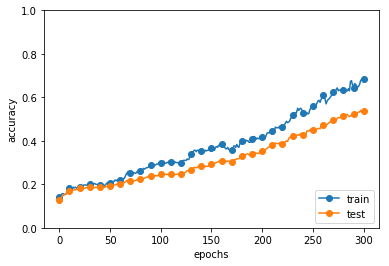

In [41]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='o', label='test', markevery=10)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 활성화 함수 + weight initialization 다르게 적용해보기!


In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [50]:
input_data = np.random.uniform(1000, 100) #1000개의 input data
node_num = 100 # 각 은닉층의 노드 개수
hidden_layer_size = 5 # 히든 레이어 5개


<img src ='시그모이드.png'  > 

In [51]:
activations = {}
x = input_data
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    
    w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 활성화 함수를 다르게 해보면서 실험해보기
    #z = sigmoid(a)
    z = sigmoid(a)
    #z = tanh(a)
    
    activations[i] = z

C:\Users\jimmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


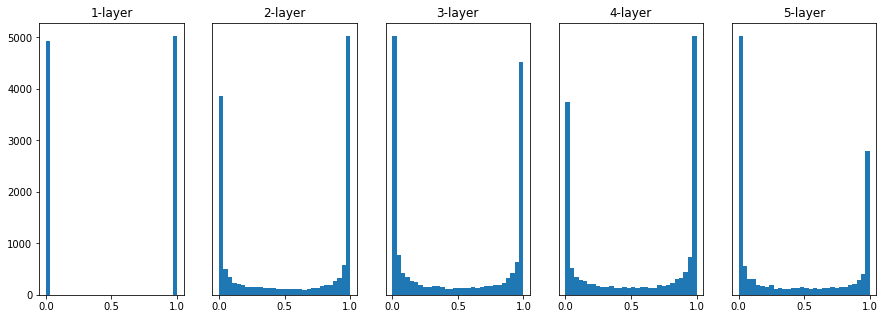

In [52]:
plt.figure(figsize=(15,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i != 0:
        plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [53]:
activations = {}
x = input_data
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 활성화 함수를 다르게 해보면서 실험해보기
    z = sigmoid(a)
    #z = ReLU(a)
    #z = tanh(a)
    
    activations[i] = z

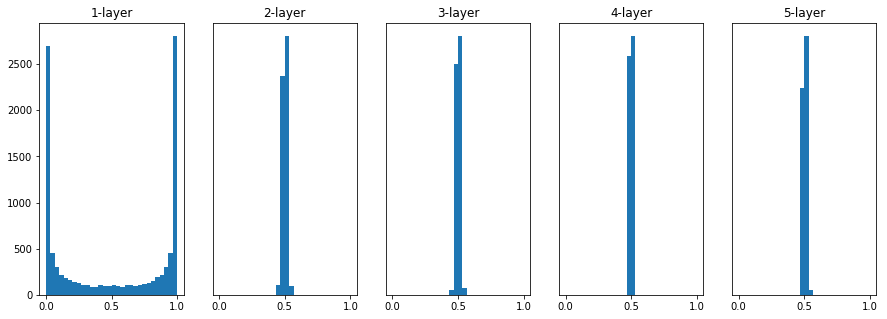

In [54]:

plt.figure(figsize=(15,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i != 0:
        plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [55]:
activations = {}
x = input_data
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 활성화 함수를 다르게 해보면서 실험해보기
    z = sigmoid(a)
    #z = ReLU(a)
    #z = tanh(a)
    
    activations[i] = z

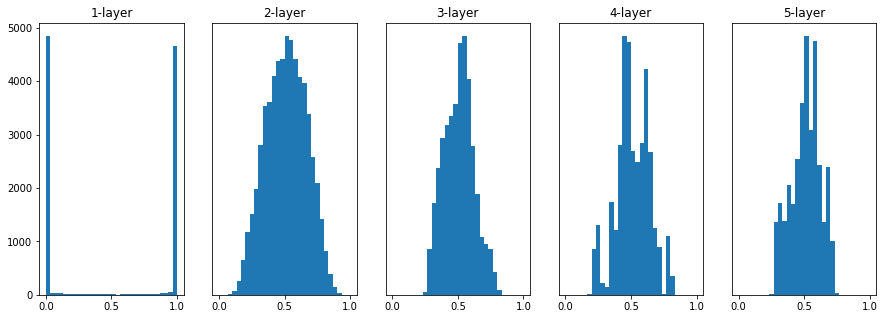

In [56]:
plt.figure(figsize=(15,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i != 0:
        plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [57]:
activations = {}
x = input_data
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    
    a = np.dot(x, w)
    
    # 활성화 함수를 다르게 해보면서 실험해보기
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)
    
    activations[i] = z

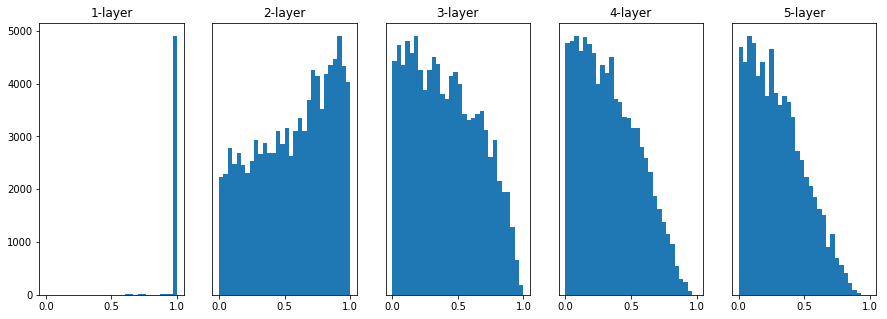

In [58]:
plt.figure(figsize=(15,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i != 0:
        plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [59]:
activations = {}
x = input_data
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    # 초깃값을 다양하게 바꿔가며 실험해보자！
    
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2/ node_num)
    
    a = np.dot(x, w)
    
    # 활성화 함수를 다르게 해보면서 실험해보기
    #z = sigmoid(a)
    z = ReLU(a)
    #z = tanh(a)
    
    activations[i] = z

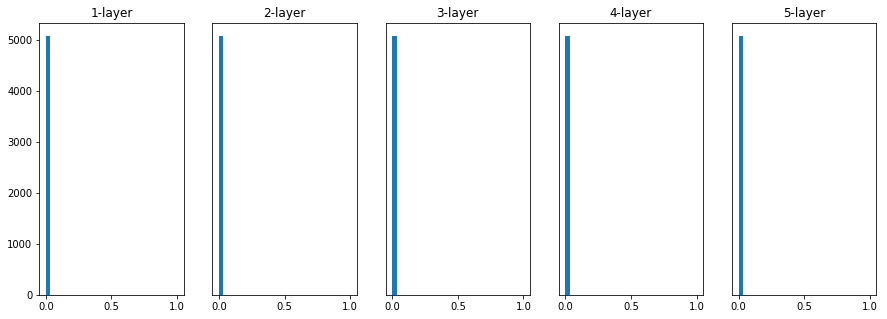

In [60]:
plt.figure(figsize=(15,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i != 0:
        plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

## 비교

In [61]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

In [62]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

In [63]:
weight_init_types = {
    'std=0.01': 0.01,
    'Xavier': 'sigmoid',
    'He': 'relu',
}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(
                        input_size=784,
                        hidden_size_list=[100, 100, 100, 100],
                        output_size=10,
                        weight_init_std=weight_type,
    )
    train_loss[key] = []

In [64]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print('========== iter: %d =========' % i)
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ':' + str(loss))

========== iter: 0 =========
Xavier:2.2954103751575854
std=0.01:2.3025523093938287
He:2.284520186290723
========== iter: 100 =========
Xavier:2.2303209439793426
std=0.01:2.3020537844016475
He:1.345364462954699
========== iter: 200 =========
Xavier:2.101103067838998
std=0.01:2.3026426848798054
He:0.6951853311051747
========== iter: 300 =========
Xavier:1.8168758669199883
std=0.01:2.299922253621169
He:0.5640056025948628
========== iter: 400 =========
Xavier:1.3736411788094667
std=0.01:2.3015235077782408
He:0.6038383896481493
========== iter: 500 =========
Xavier:0.7839813075486677
std=0.01:2.299177668138453
He:0.3707355374582248
========== iter: 600 =========
Xavier:0.6888121263147219
std=0.01:2.3043082430554516
He:0.33288903792613445
========== iter: 700 =========
Xavier:0.6053179899313239
std=0.01:2.297802490088687
He:0.3853106506309364
========== iter: 800 =========
Xavier:0.4314219302459198
std=0.01:2.3023299264159904
He:0.21400270498139104
========== iter: 900 =========
Xavier:0.458

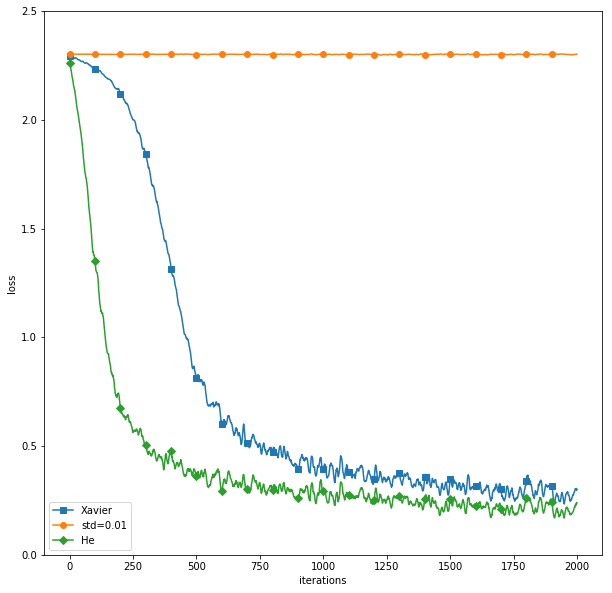

In [65]:
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
plt.figure(figsize=(10,10))

for key in weight_init_types.keys():
    plt.plot(
        x,
        smooth_curve(train_loss[key]),
        marker=markers[key],
        markevery=100,
        label=key,
    )
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 정리!

# 뉴럴넷 아키텍쳐 구성할시 주의해야할 점!

## 신경망 구성 단계

* 최대한 각 layer에 속한 유닛이 다양한 값을 갖게 해야 한다! 
> 기존의 sigmoid로 활성화를 주면 은닉층이 깊어질 수록 유닛 값의 분포가 점점 동일해짐
> weight 초기값을 동일하게 0으로 주는건 절대안됨! 따라서 weight 초기값과 batch normalization이 중요!
> batch normalization은 affine 계층과 활성화 계층의 중간단계에 구성 해야함.

## 오버피팅 문제

* 신경망의 깊이가 깊어지고 유닛의 수가 많아 질수록 오버피팅 될 가능성이 높음.

> dropout으로 데이터가 mini_batch로 들어갈 때마다 유닛들을 무작위로 죽여 오버피팅 방지! 

## 이후 역전파 단계에서 최적해 찾는 속도 문제

* 전체 데이터를 한번 학습할때마다 weight를 갱신하게 되면 전체 데이터를 고려할 수 있으나 학습속도가 현저하게 떨어짐. learning rate를 크게 주자니 코스트가 발산할 우려가 생김

> 그로 인해 mini batch를 주어 데이터의 일부만으로 weight를 업데이트 하는 최적화 알고리즘이 개발됨 - SGD 

> SGD 알고리즘이 갖고 있는 문제점을 해결하기 위해 다양한 알고리즘이 나오게 됨 - Mometum, Adam 